# 0.0. IMPORTS

In [59]:
import inflection
import warnings
import datetime
import pickle
import random
import math
import pandas  as pd
import numpy   as np
import seaborn as sns

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from xgboost               import XGBRegressor
from boruta                import BorutaPy
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from matplotlib            import gridspec
from IPython.core.display  import HTML
from IPython.display       import Image

## 0.1. Helper Functions

In [60]:
def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [22, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None

    sns.set()
    

    
def cramer_v( x, y):
    #confusion matrix
    cm = pd.crosstab(x, y).values
    
    #sum of observations
    n = cm.sum()
    
    #number of lines and columns
    r, k = cm.shape
    
    #chi²
    chi2 = ss.chi2_contingency( cm )[0]
    
    #bias correction
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k-1)**2 / (n - 1)
    rcorr = r - (r-1)**2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr - 1)))



def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name:' : model_name,
                          'MAE:' : mae,
                          'MAPE:' : mape,
                          'RMSE:' : rmse}, index = [0])



def mean_percentage_error(y, yhat):
    return np.mean( (y - yhat ) / y )



def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'KFold Number: {k}')
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date  = x_training['date'].max() - datetime.timedelta(days=k-1*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        
        #validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # reserve performance of each kfold iteration
        mae_list.append(m_result['MAE:'])
        mape_list.append(m_result['MAPE:'])
        rmse_list.append(m_result['RMSE:'])
        
        
    return pd.DataFrame({'Model Name': model_name, 
                         'MAE CV': round(np.mean(mae_list), 2).astype(str) + '+/-' + round(np.std(mae_list), 2).astype(str),
                         'MAPE CV':round(np.mean(mape_list), 2).astype(str) + '+/-' + round(np.std(mape_list), 2).astype(str),
                         'RMSE CV':round(np.mean(rmse_list), 2).astype(str) + '+/-' + round(np.std(rmse_list), 2).astype(str)}, index=[0])

In [61]:
jupyter_settings()
warnings.filterwarnings('ignore')

##  0.2. Loading data

In [62]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DATA DESCRIPTION

In [63]:
df1 = df_raw.copy()

## 1.1. Rename Columns 

In [64]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

In [65]:
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

In [66]:
# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [67]:
print(f' Number of Rows: {df1.shape[0]}')
print(f' Number of Cols: {df1.shape[1]}')

 Number of Rows: 1017209
 Number of Cols: 18


## 1.3. Data Dtypes

In [68]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [69]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA 

In [70]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1[['competition_open_since_month', 'date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1[['competition_open_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)                   

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval 
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'April', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

## 1.6. Change Types

In [71]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Statistics Descriptive

In [72]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [73]:
min_      = pd.DataFrame(num_attributes.apply(np.min)).T
max_      = pd.DataFrame(num_attributes.apply(np.max)).T
mean_     = pd.DataFrame(num_attributes.apply(np.mean)).T
median_   = pd.DataFrame(num_attributes.apply(np.median)).T
std_      = pd.DataFrame(num_attributes.apply(np.std)).T
range_    = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew_     = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis_ = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
data_statistical = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
data_statistical.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [74]:
data_statistical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [75]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

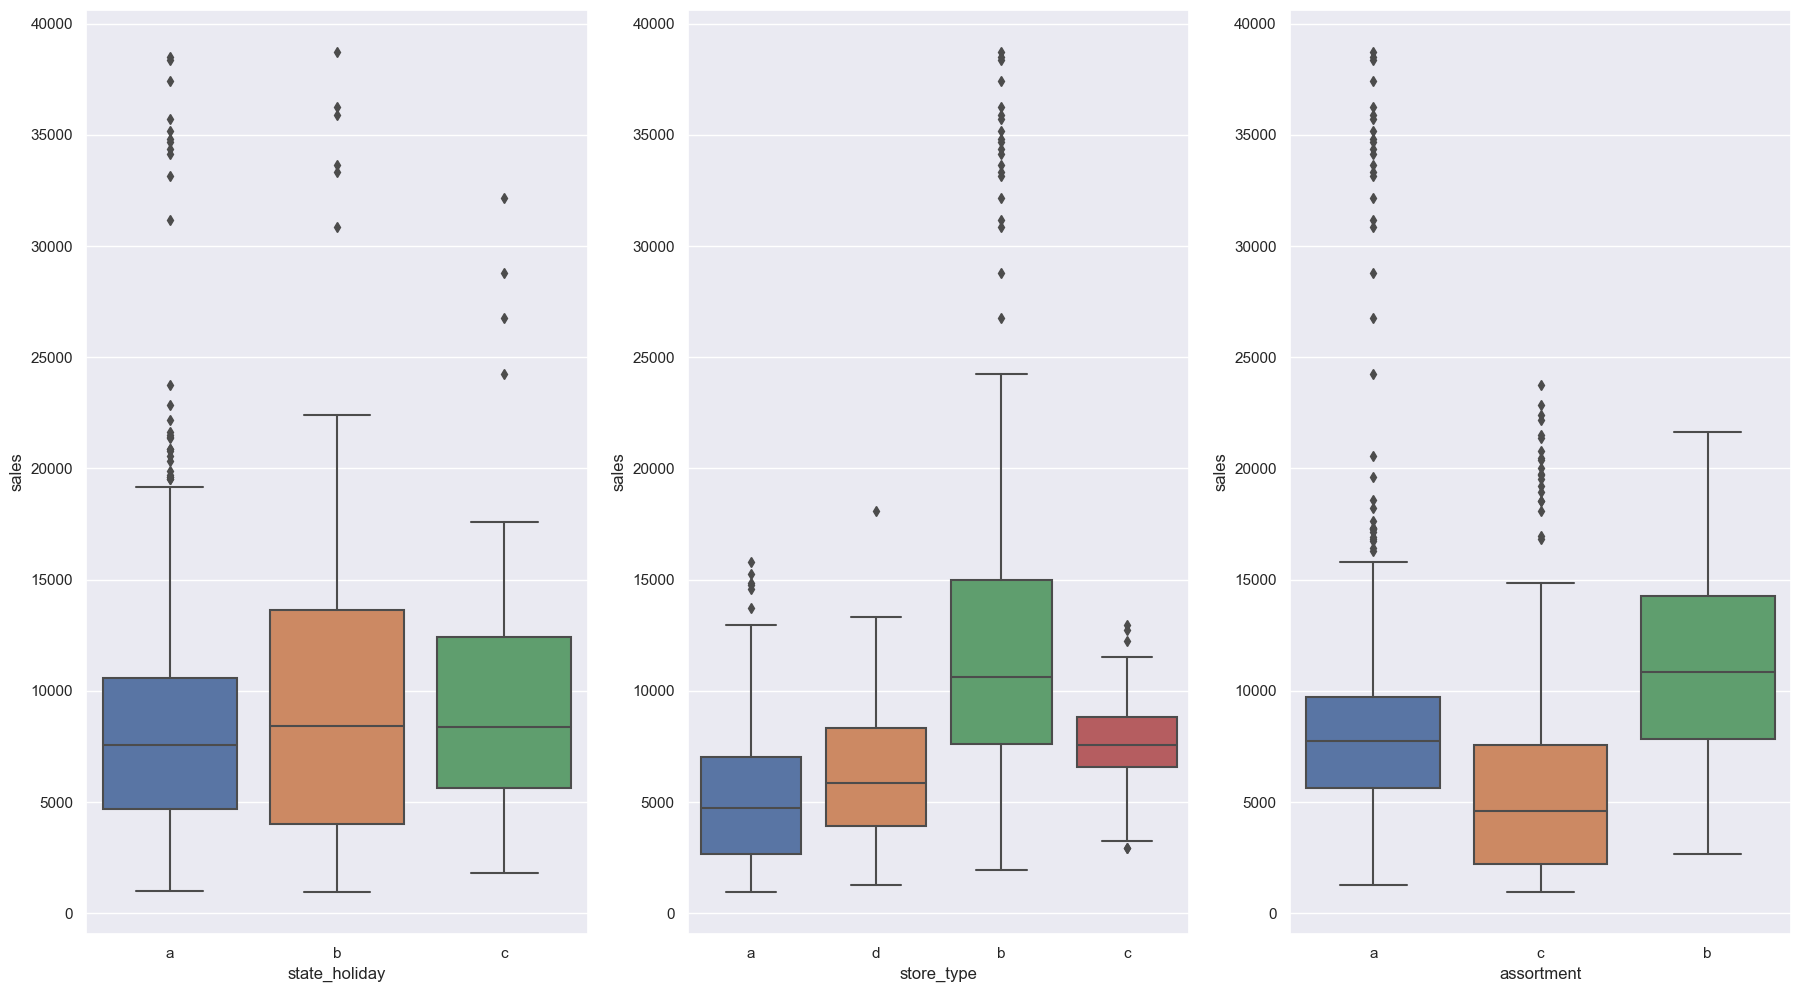

In [76]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
ax = sns.boxplot(x = 'state_holiday', y= 'sales', data = aux1)

plt.subplot(1, 3, 2)
ax1 = sns.boxplot(x = 'store_type', y= 'sales', data = aux1)

plt.subplot(1, 3, 3)
ax2 = sns.boxplot(x = 'assortment', y= 'sales', data = aux1)

plt.show()

# 2.0. FEATURE ENGINERING

In [77]:
df2 = df1.copy()

## 2.1. Hypothesis Creation

### 2.1.1 Hypothesis Mindmap

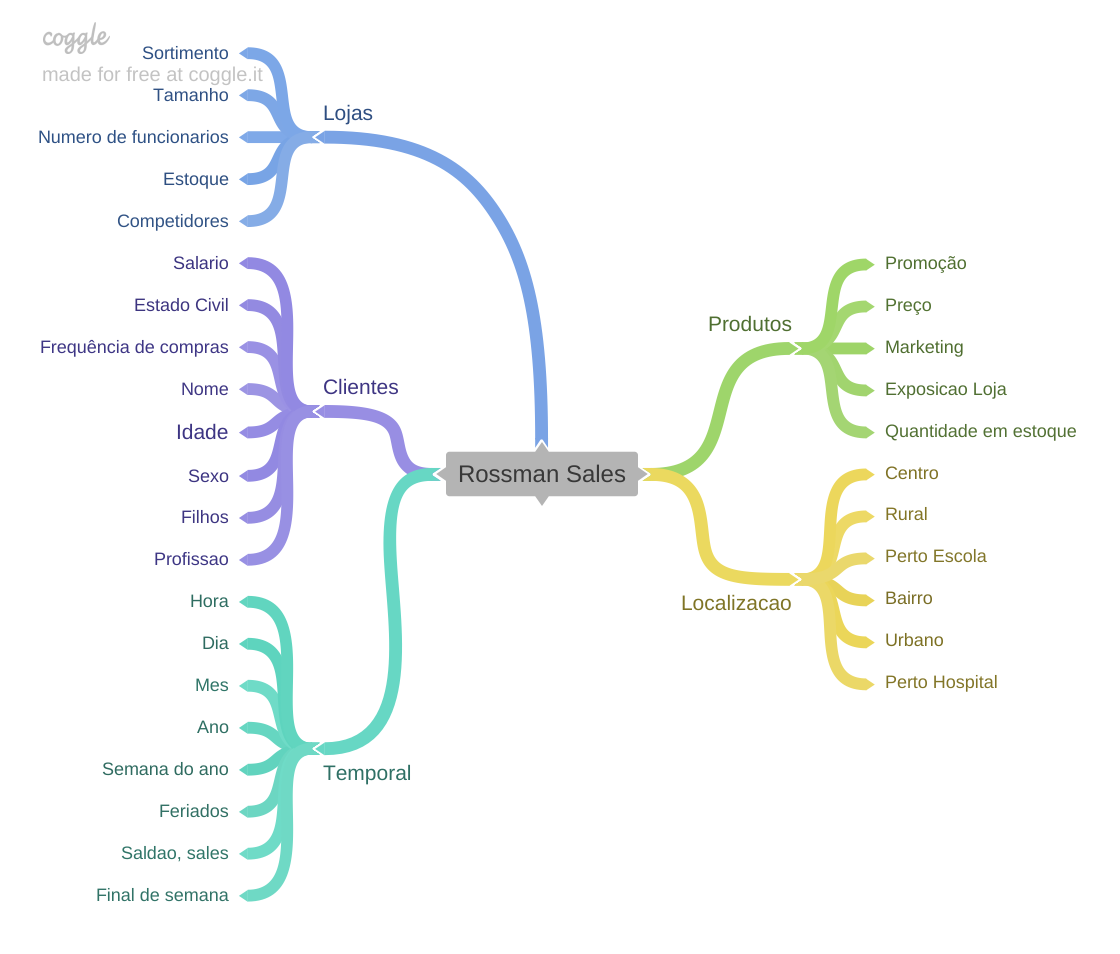

In [78]:
Image('img/Rossman_Sales.png')

###  2.1.2 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores a mais tempo deveriam vender mais

###  2.1.3 Products Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais 

**5.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**6.** Lojas com promoçoes ativas por mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

###  2.1.4 Temporal Hypothesis

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2. Final List of Hypothesis

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais proximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes

**11.** Lojas deveriam vender menos nos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Feature Engineering 

In [79]:
# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# day
df2['day'] = df1['date'].dt.day

# week of year
df2['week_of_year'] = df1['date'].dt.isocalendar().week

# year week
df2['year_week'] = df1['date'].dt.strftime( '%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), axis = 1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                      'extra' if x == 'b' else 'extended') 

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                            'easter_holiday' if x == 'b' else 
                                                            'chrismas' if x == 'c' else 'regular_day') 

In [80]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. DATA FILTERING

In [81]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [82]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtering Cols

In [83]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [84]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales'>

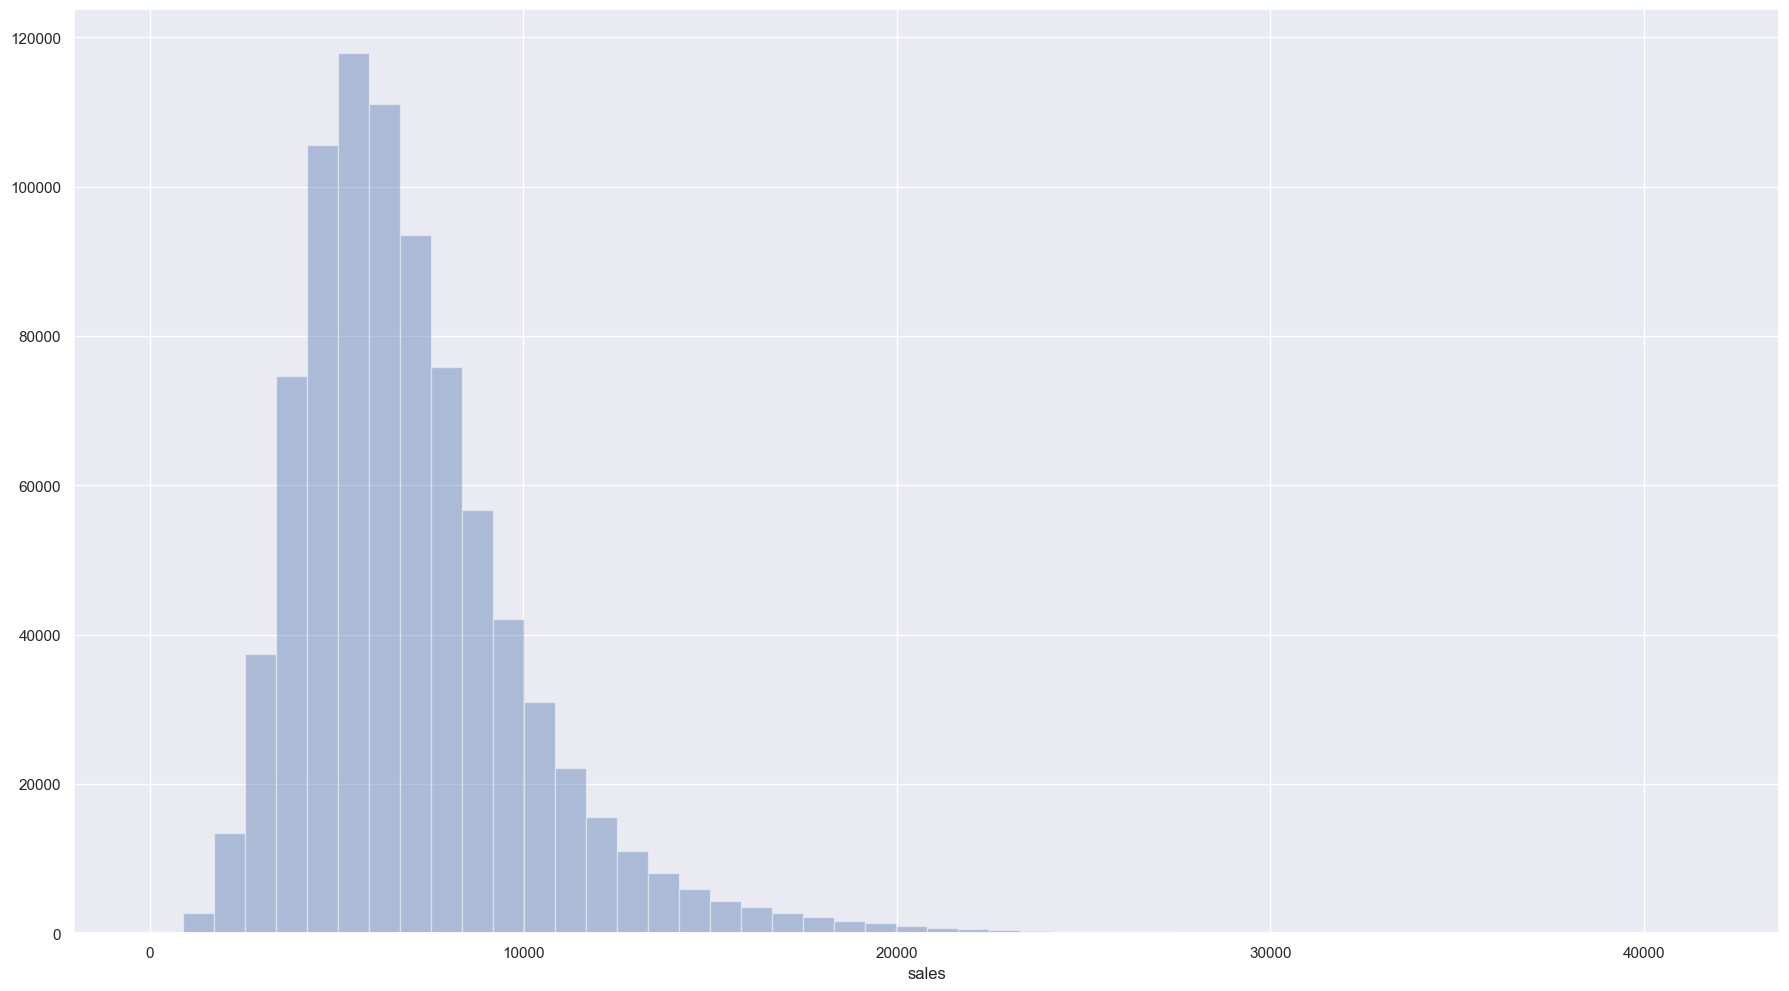

In [85]:
sns.distplot( df4['sales'], kde=False  )

### 4.1.2. Numerical Variable

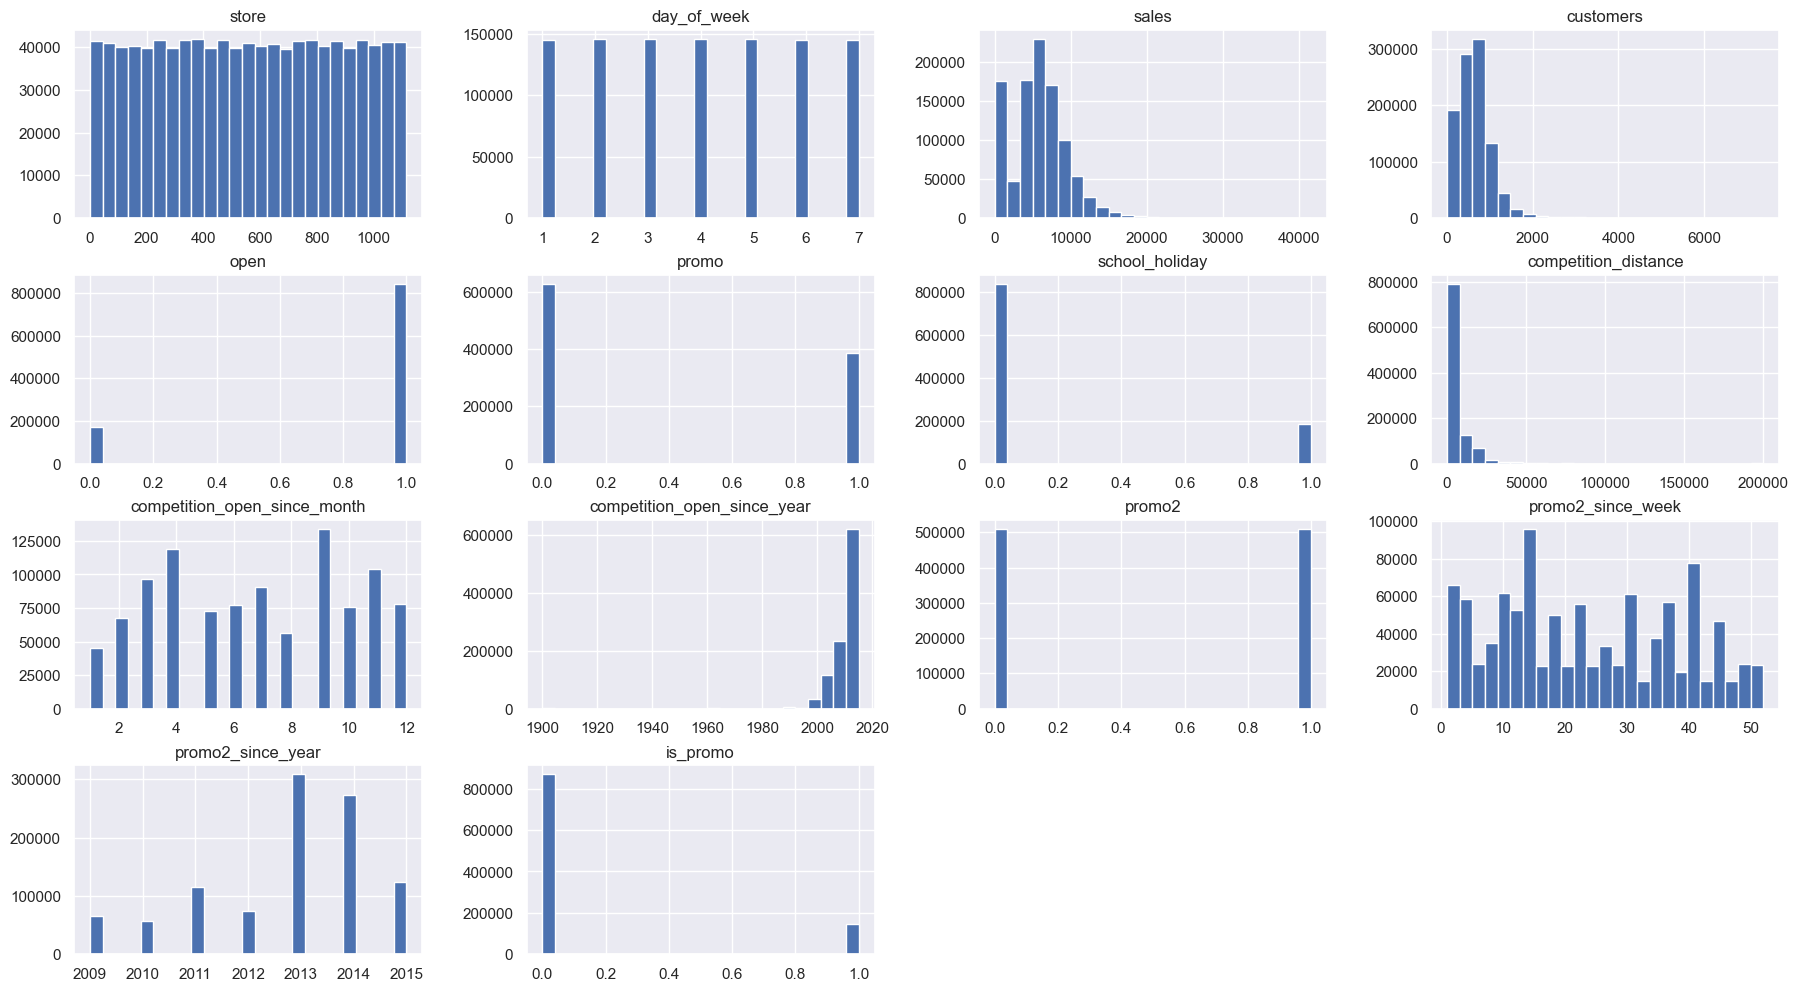

In [86]:
num_attributes.hist( bins=25 );

### 4.1.3. Categorical Variable

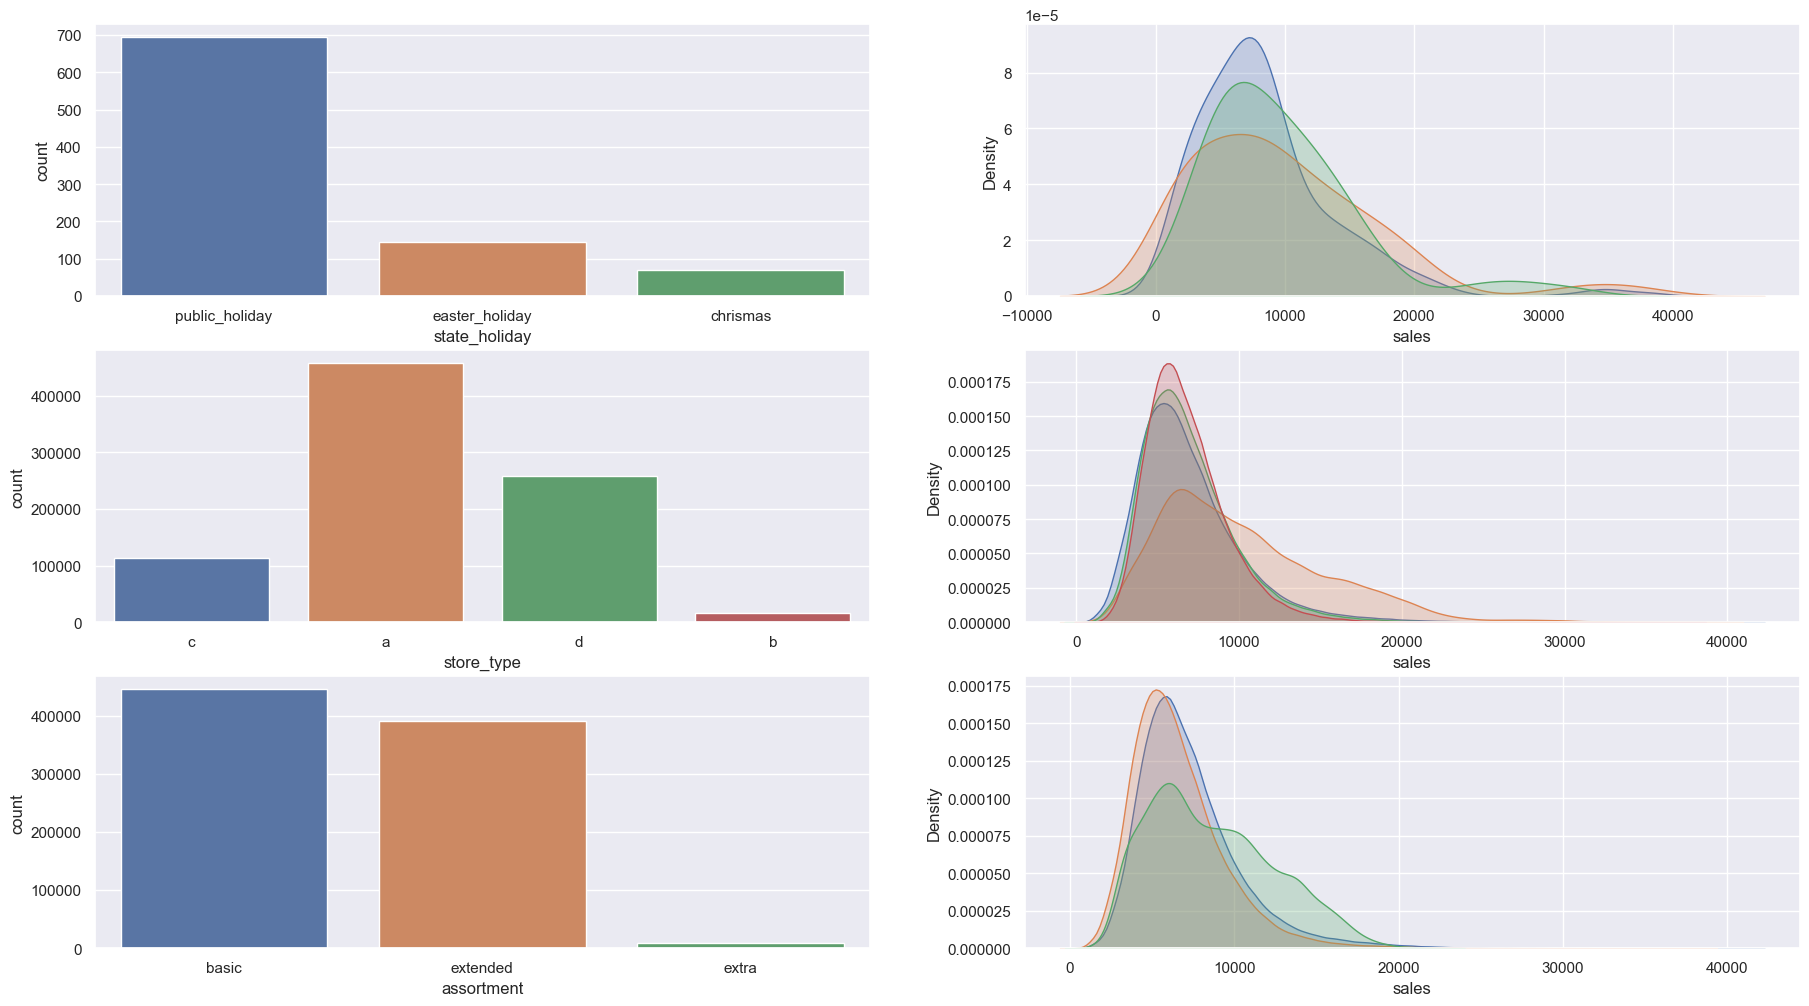

In [87]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( data = a, x = 'state_holiday' )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'chrismas']['sales'], label='chrismas', fill=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( data = df4 , x = 'store_type' )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( data = df4, x = 'assortment' )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True );

## 4.2. Bivariate Analysis

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

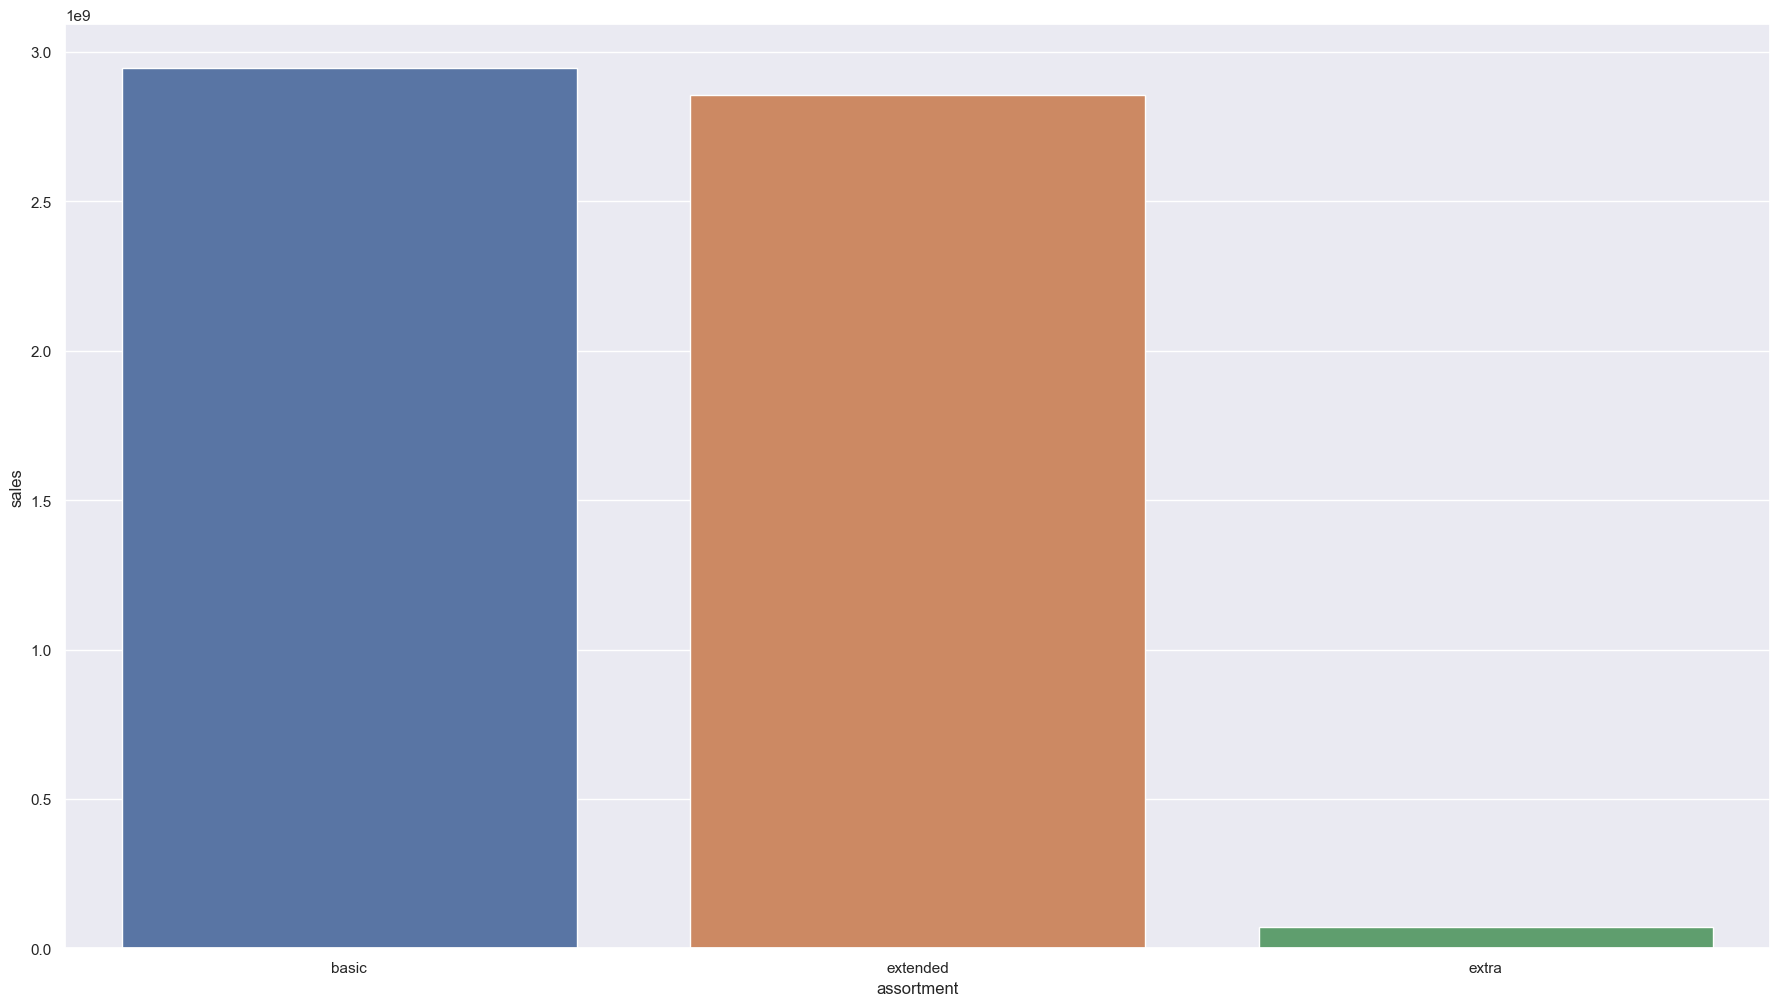

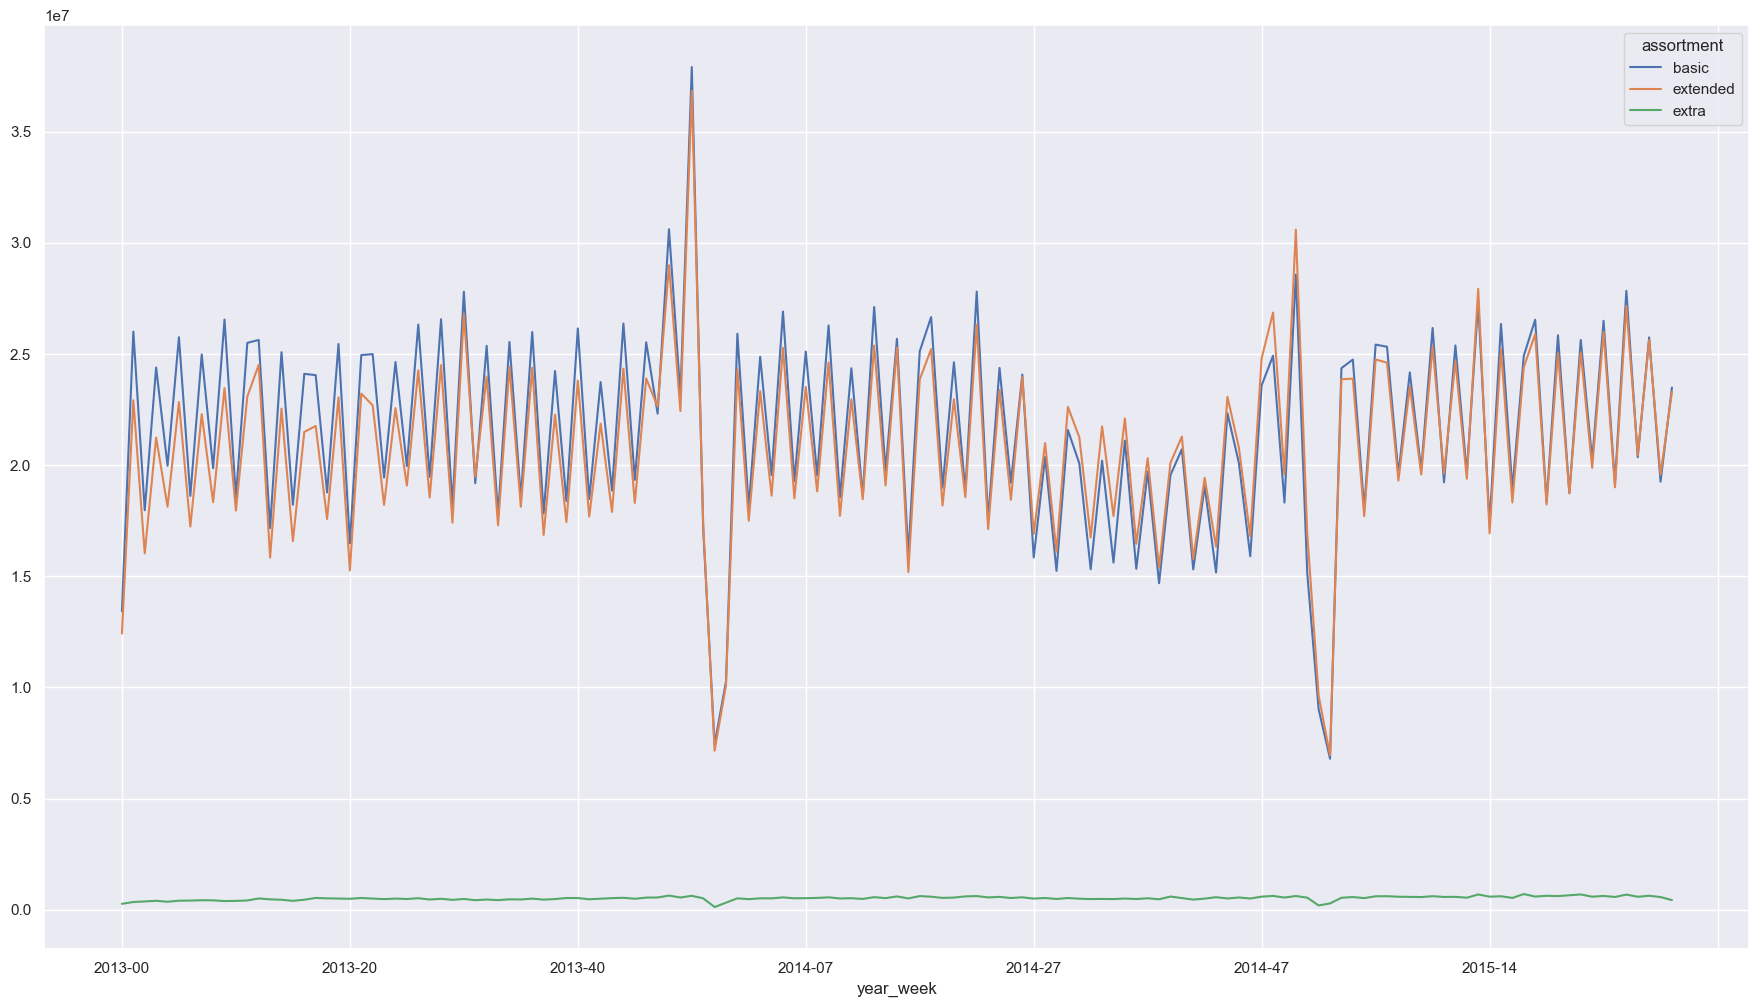

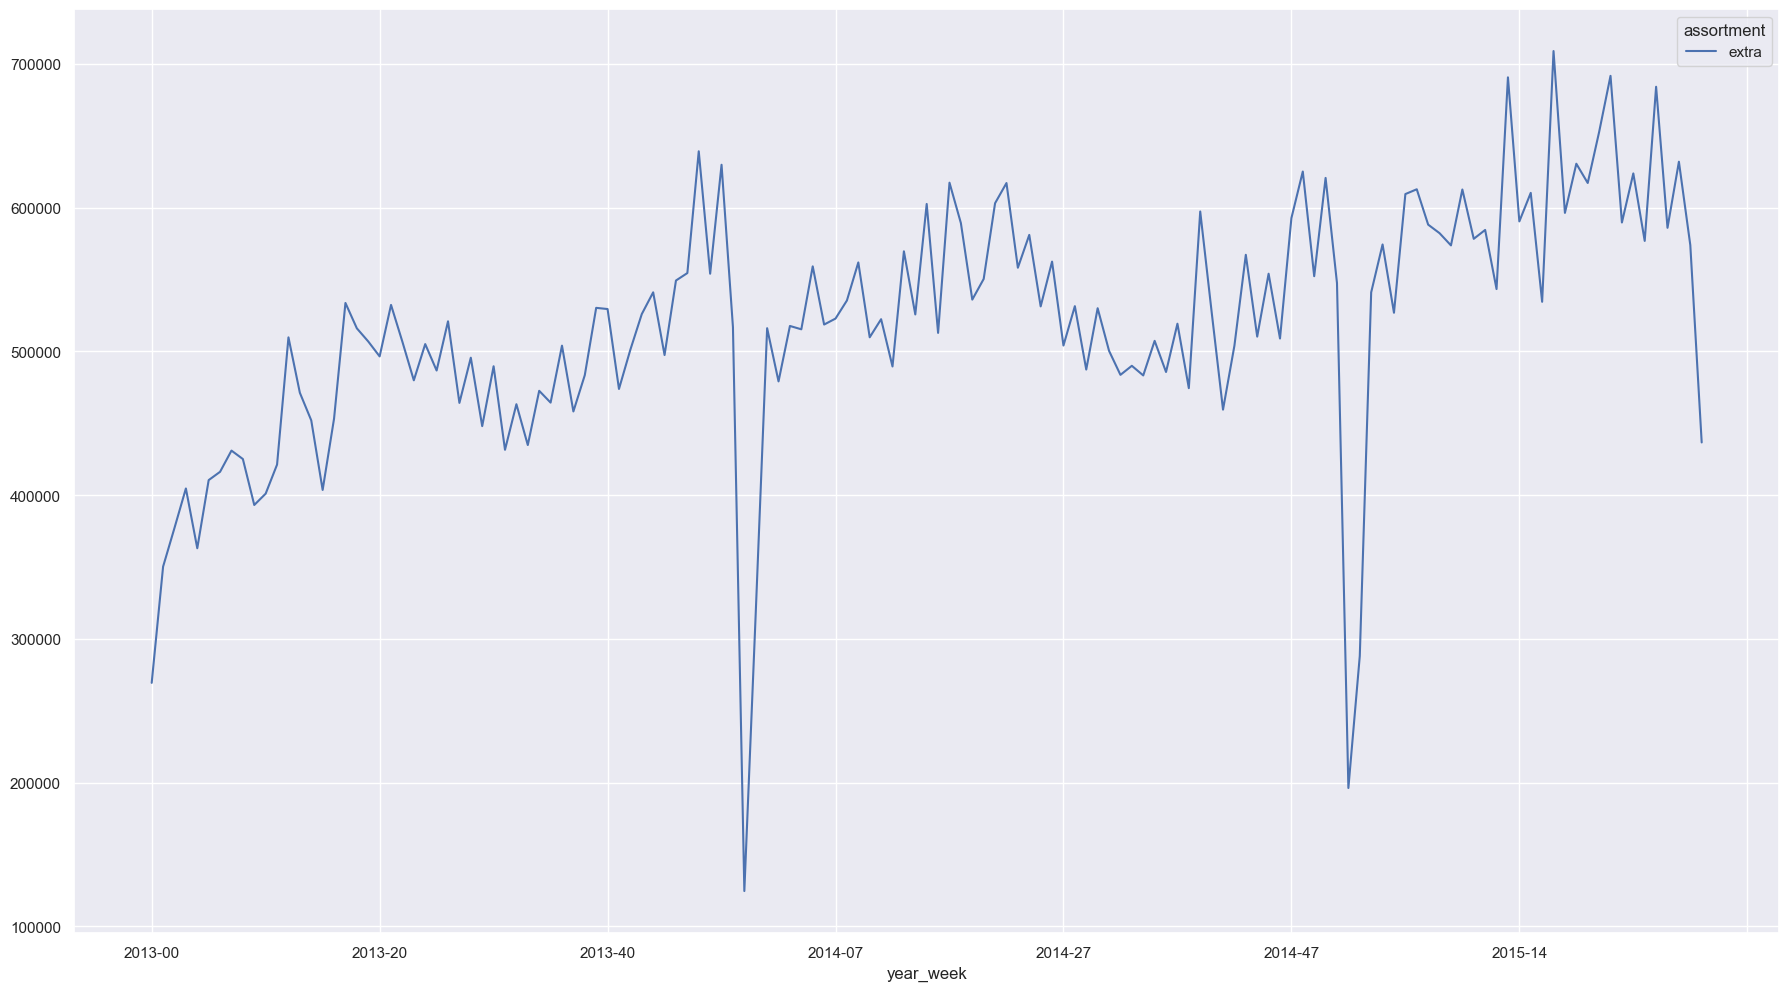

In [88]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

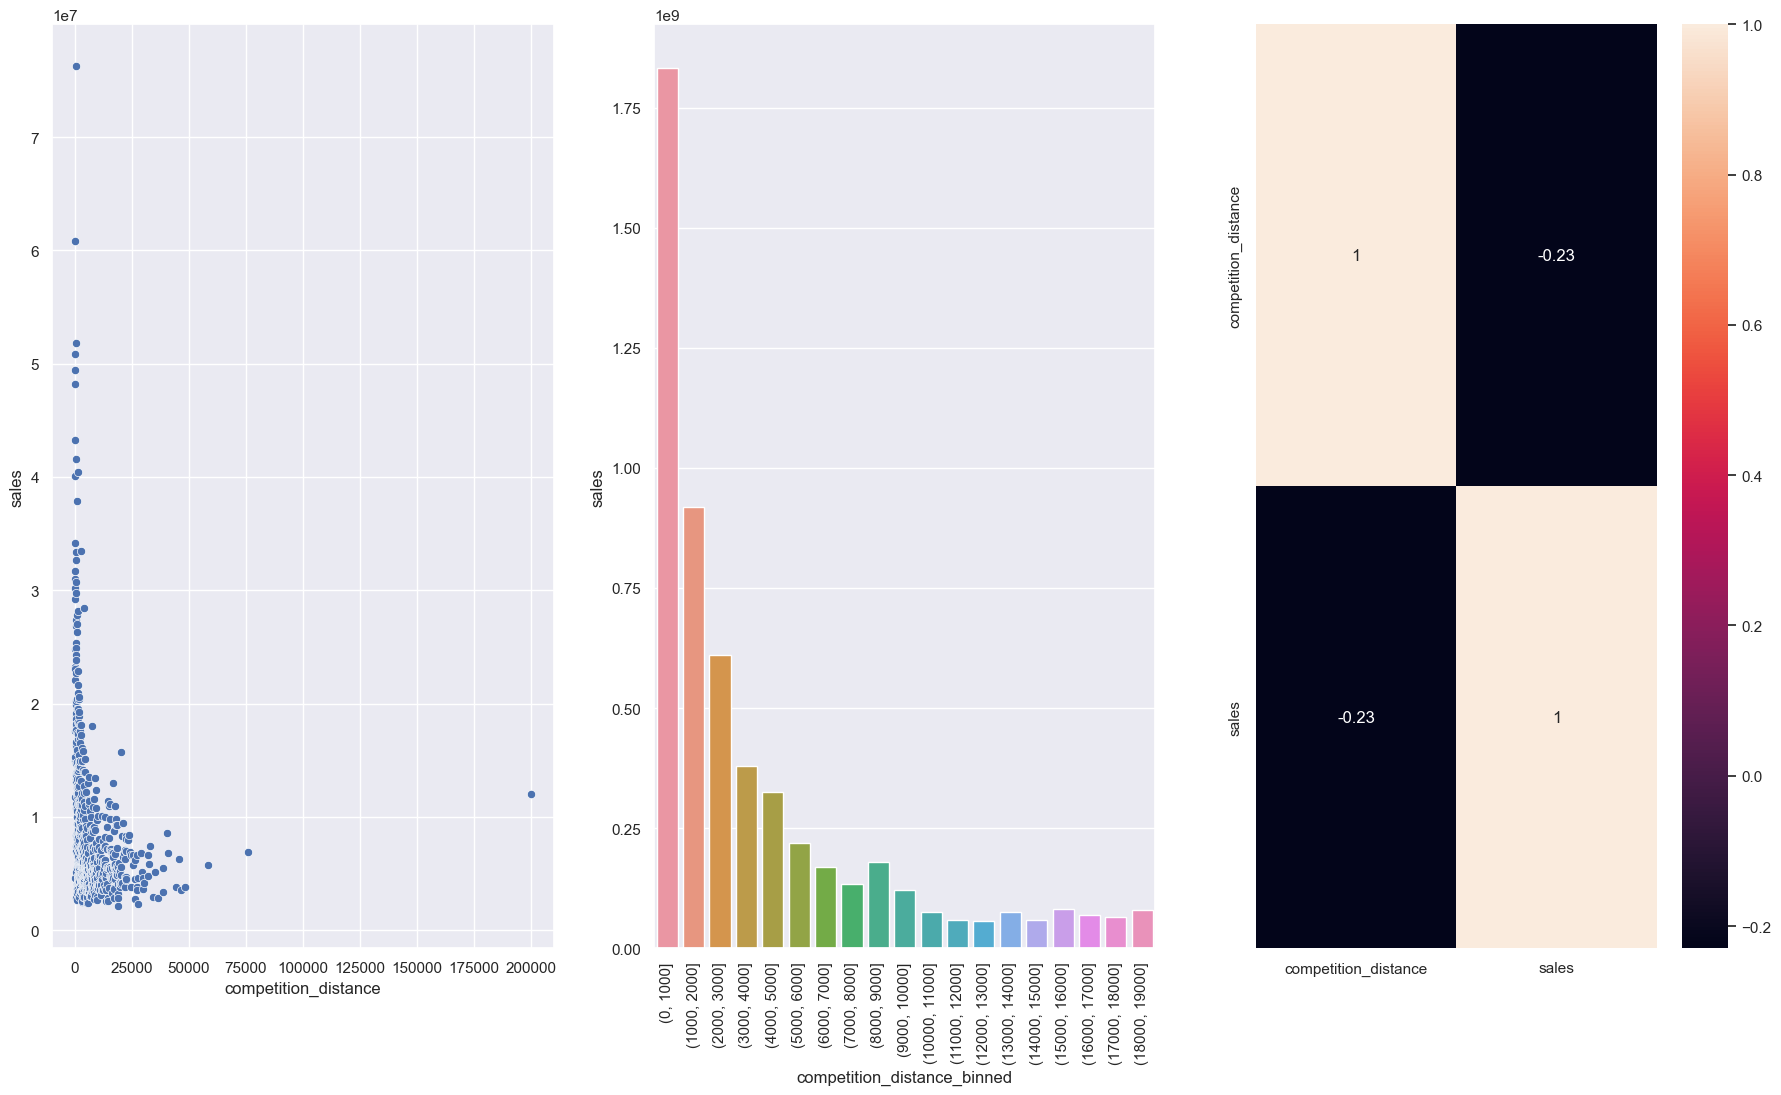

In [89]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )

aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

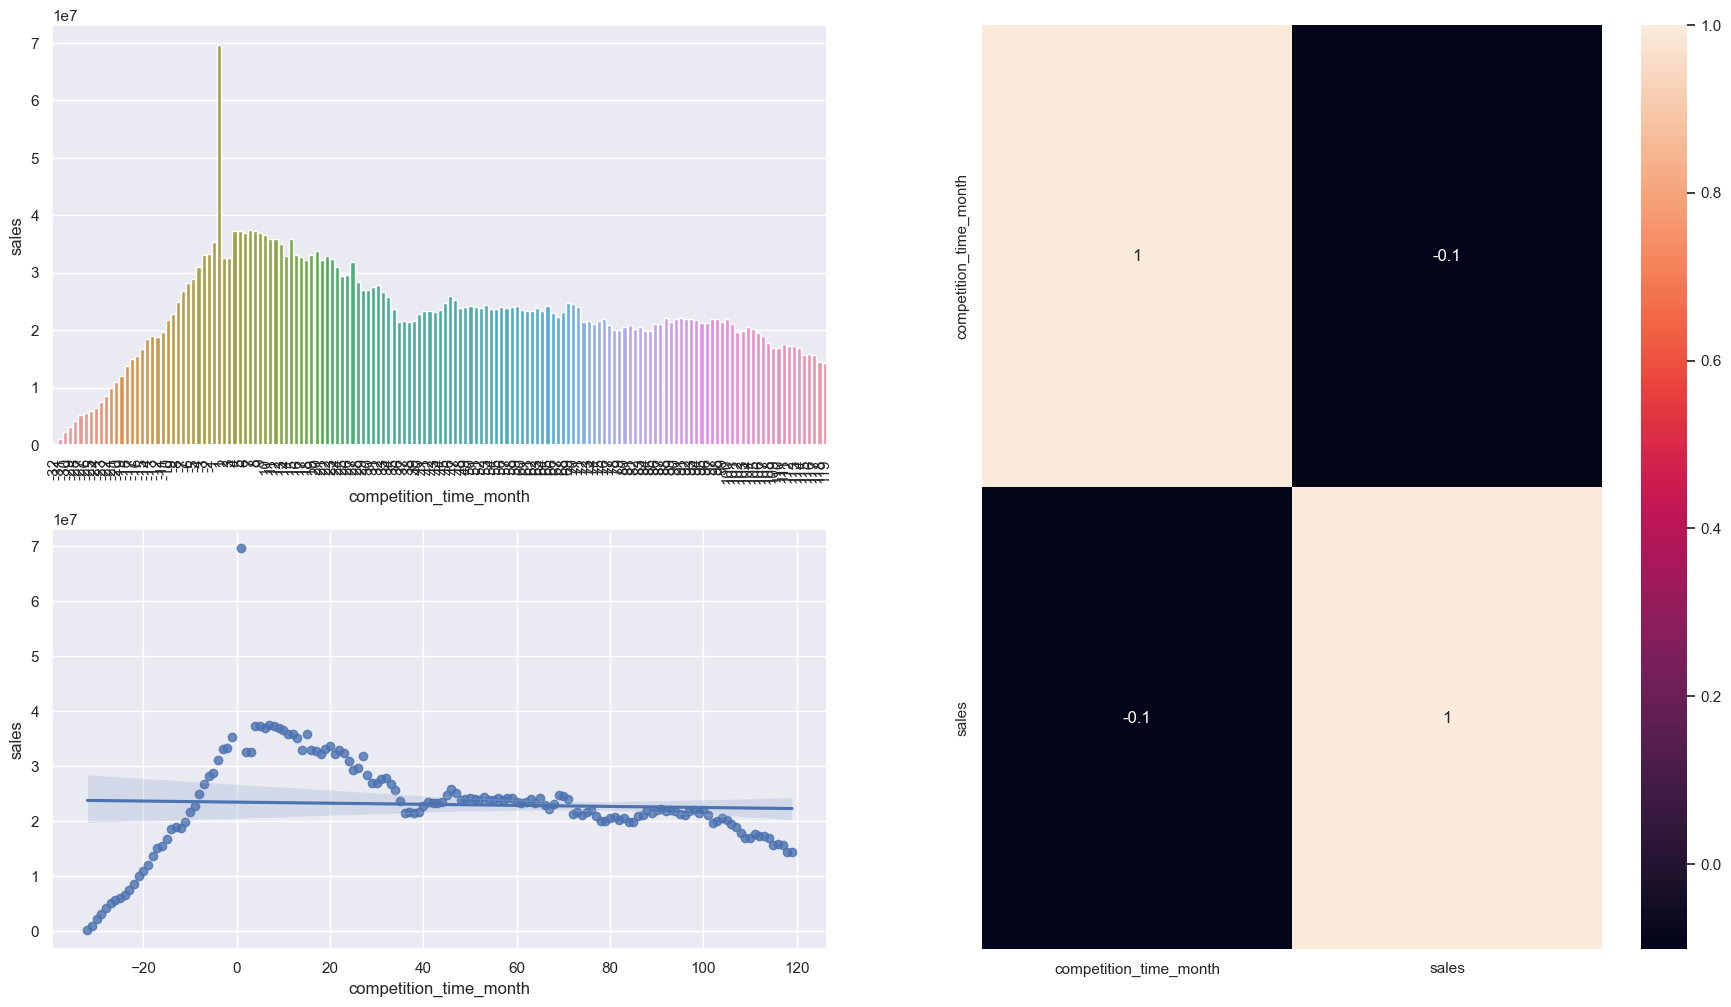

In [90]:
grid = gridspec.GridSpec(2,2)

plt.subplot( grid[0,0] )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,0] )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( grid[:,1] )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promoções ativas por mais tempo vendem menos depois de determinado periodo de tempo

In [91]:
h4 = df4[['promo_time_week', 'sales'] ].groupby('promo_time_week').sum().reset_index()

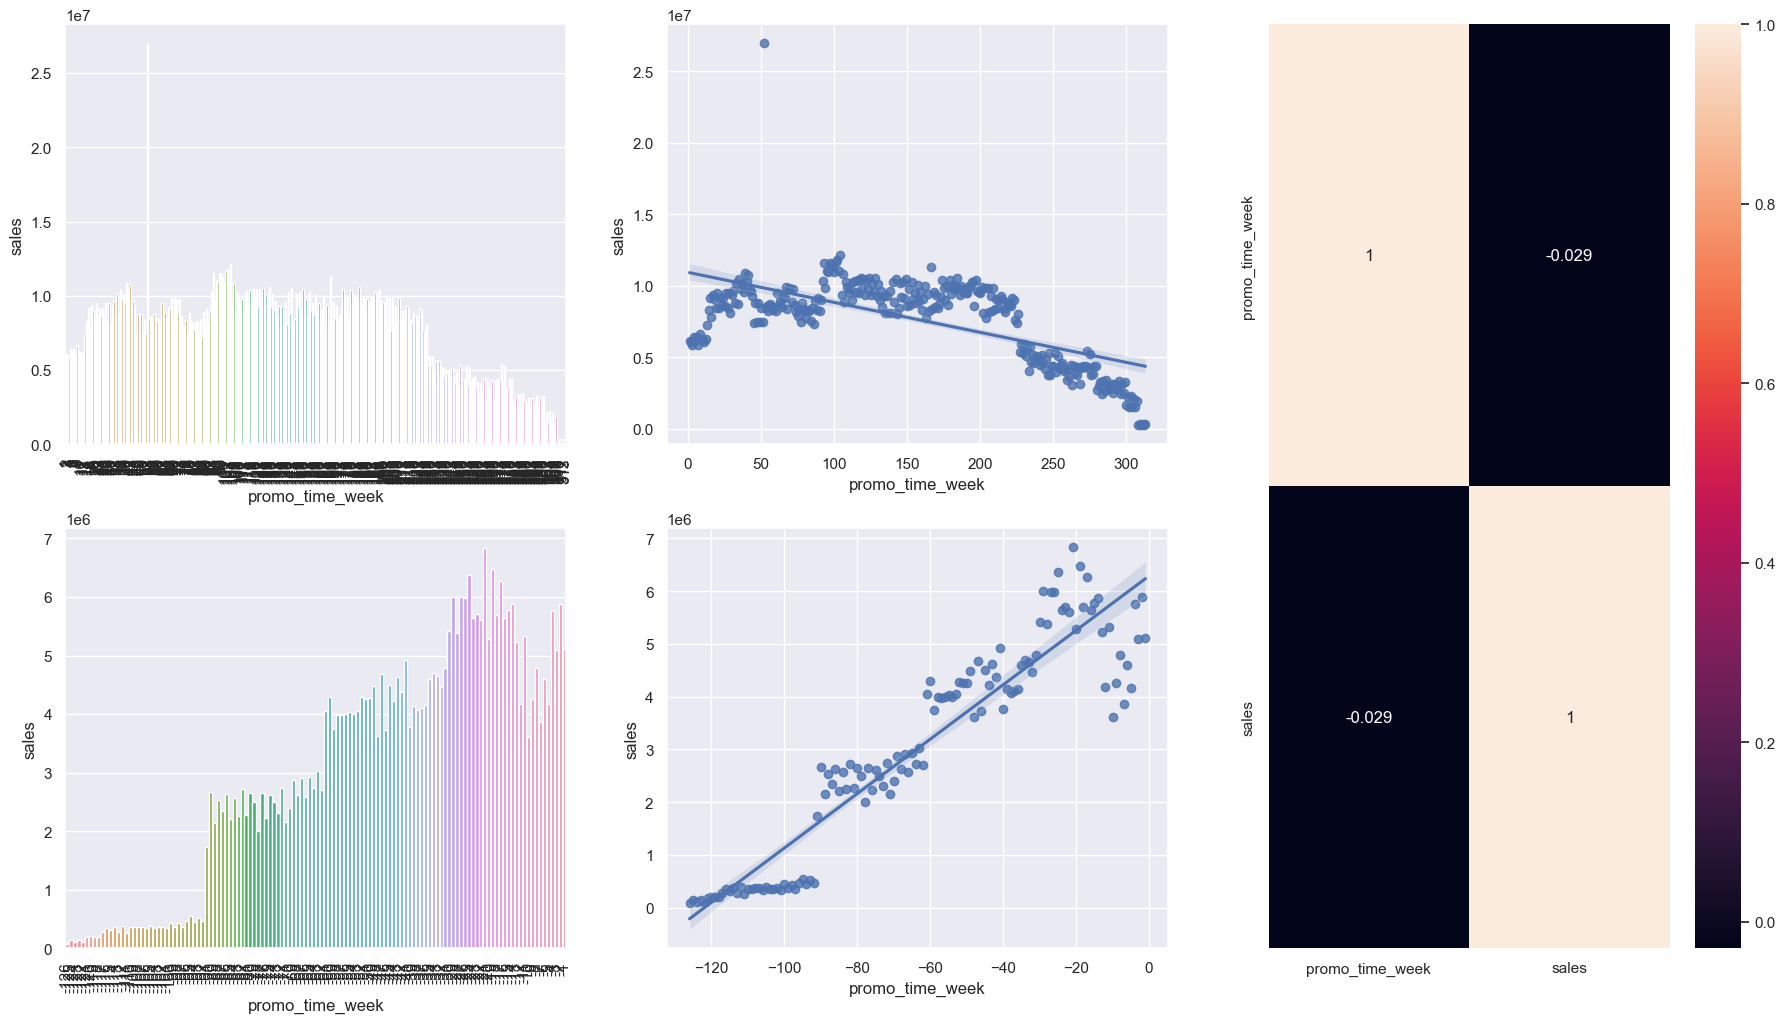

In [92]:
grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
h4_aux1 = h4[h4['promo_time_week'] > 0 ]
sns.barplot(x='promo_time_week', y='sales', data=h4_aux1)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=h4_aux1)

plt.subplot(grid[1,0])
h4_aux2 = h4[h4['promo_time_week'] < 0 ]
sns.barplot(x='promo_time_week', y='sales', data=h4_aux2);
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=h4_aux2)

plt.subplot(grid[:,2])
sns.heatmap(h4.corr(method='pearson'), annot=True);

### **H5.** Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** Lojas com mais promoções consecutivas vendem menos

In [93]:
h5 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values('sales').reset_index()

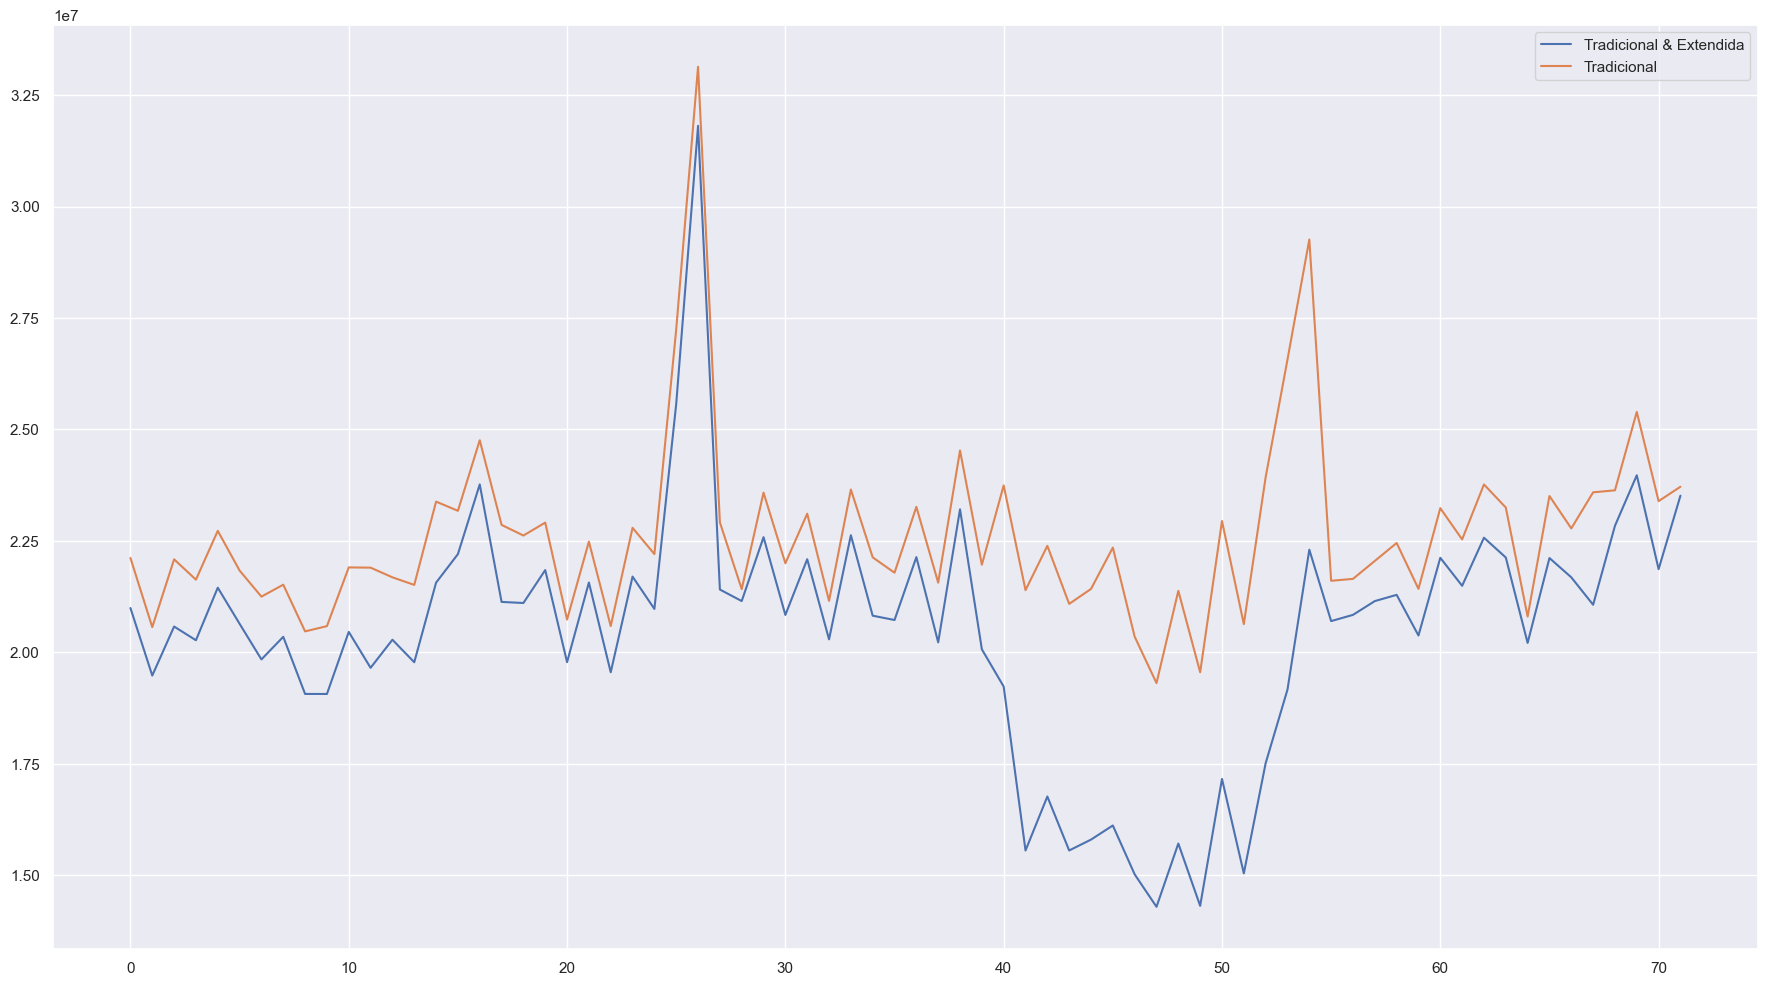

In [94]:
h5_aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1 )][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
ax = h5_aux1.plot()


h5_aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
h5_aux2.plot(ax = ax)

ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);

### H6.  Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas abertas durante o feriado de natal vendem menos

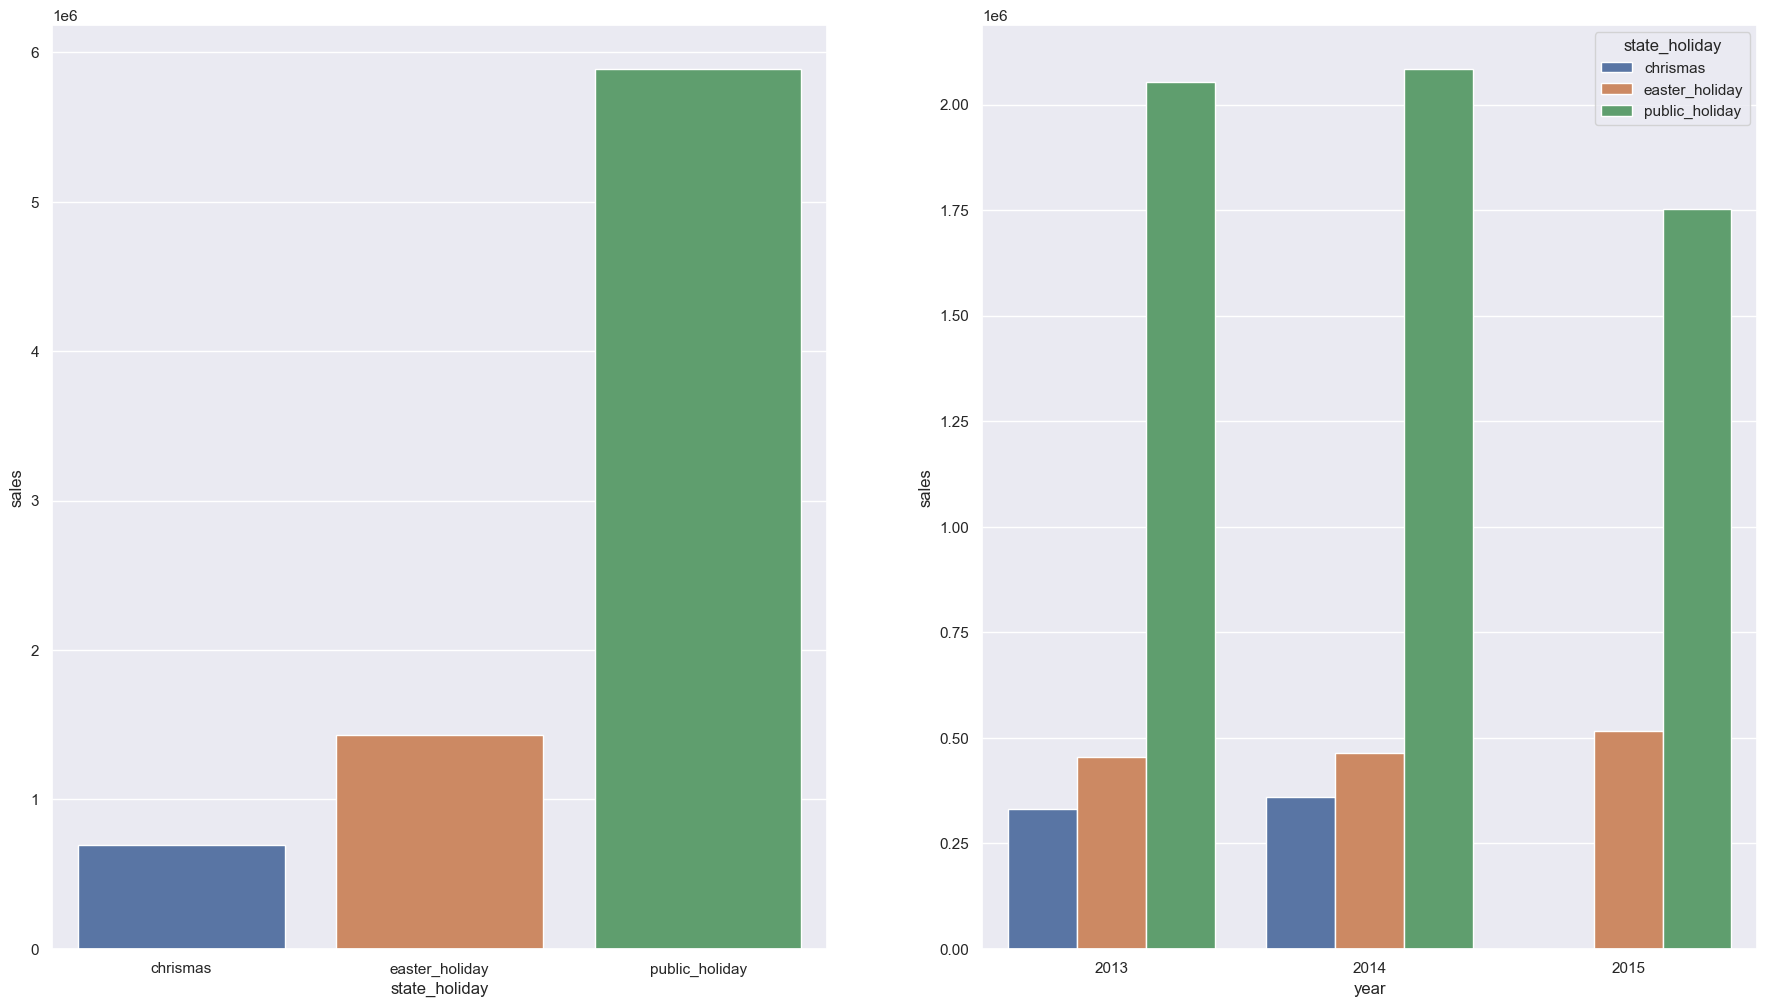

In [95]:
h6 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
h6_aux1 = h6[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x= 'state_holiday', y = 'sales', data = h6_aux1)

plt.subplot(1,2,2)
h6_aux2 = h6[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = h6_aux2);

### H7. Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos

<AxesSubplot:>

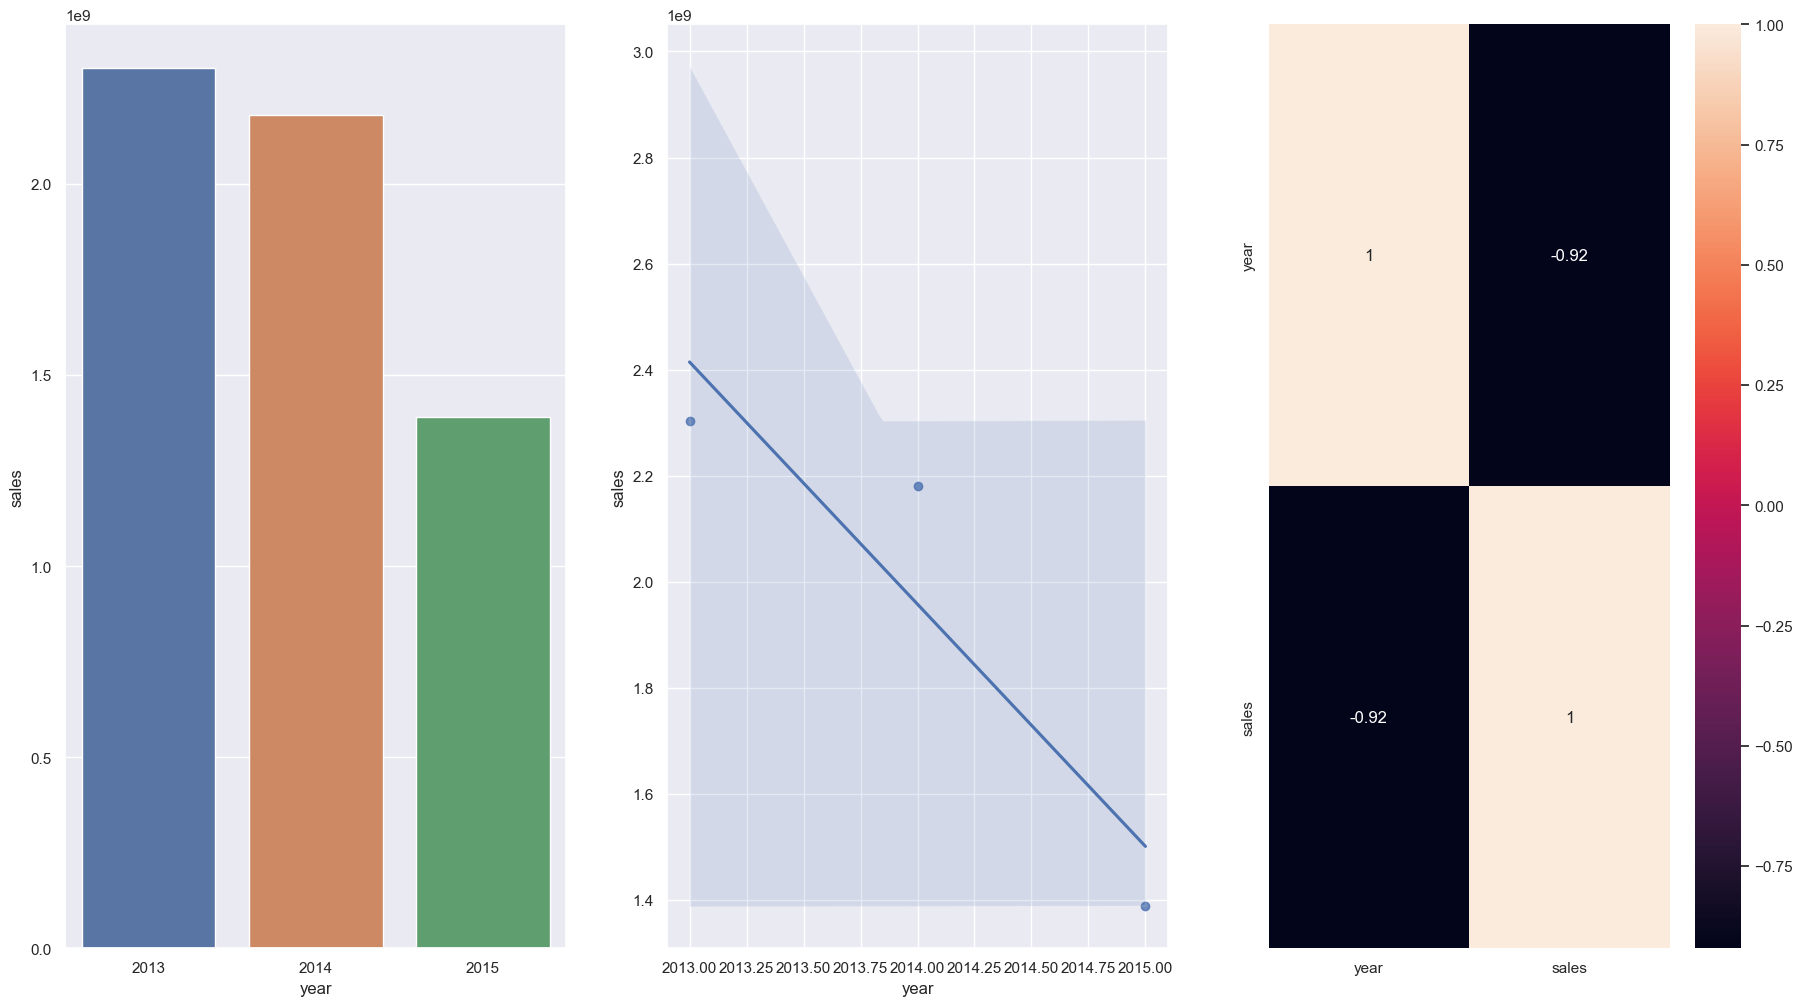

In [96]:
h7 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data= h7);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data= h7);

plt.subplot(1,3,3)
sns.heatmap(h7.corr(method='pearson'), annot= True)

### H8. Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos ao longo dos anos

<AxesSubplot:>

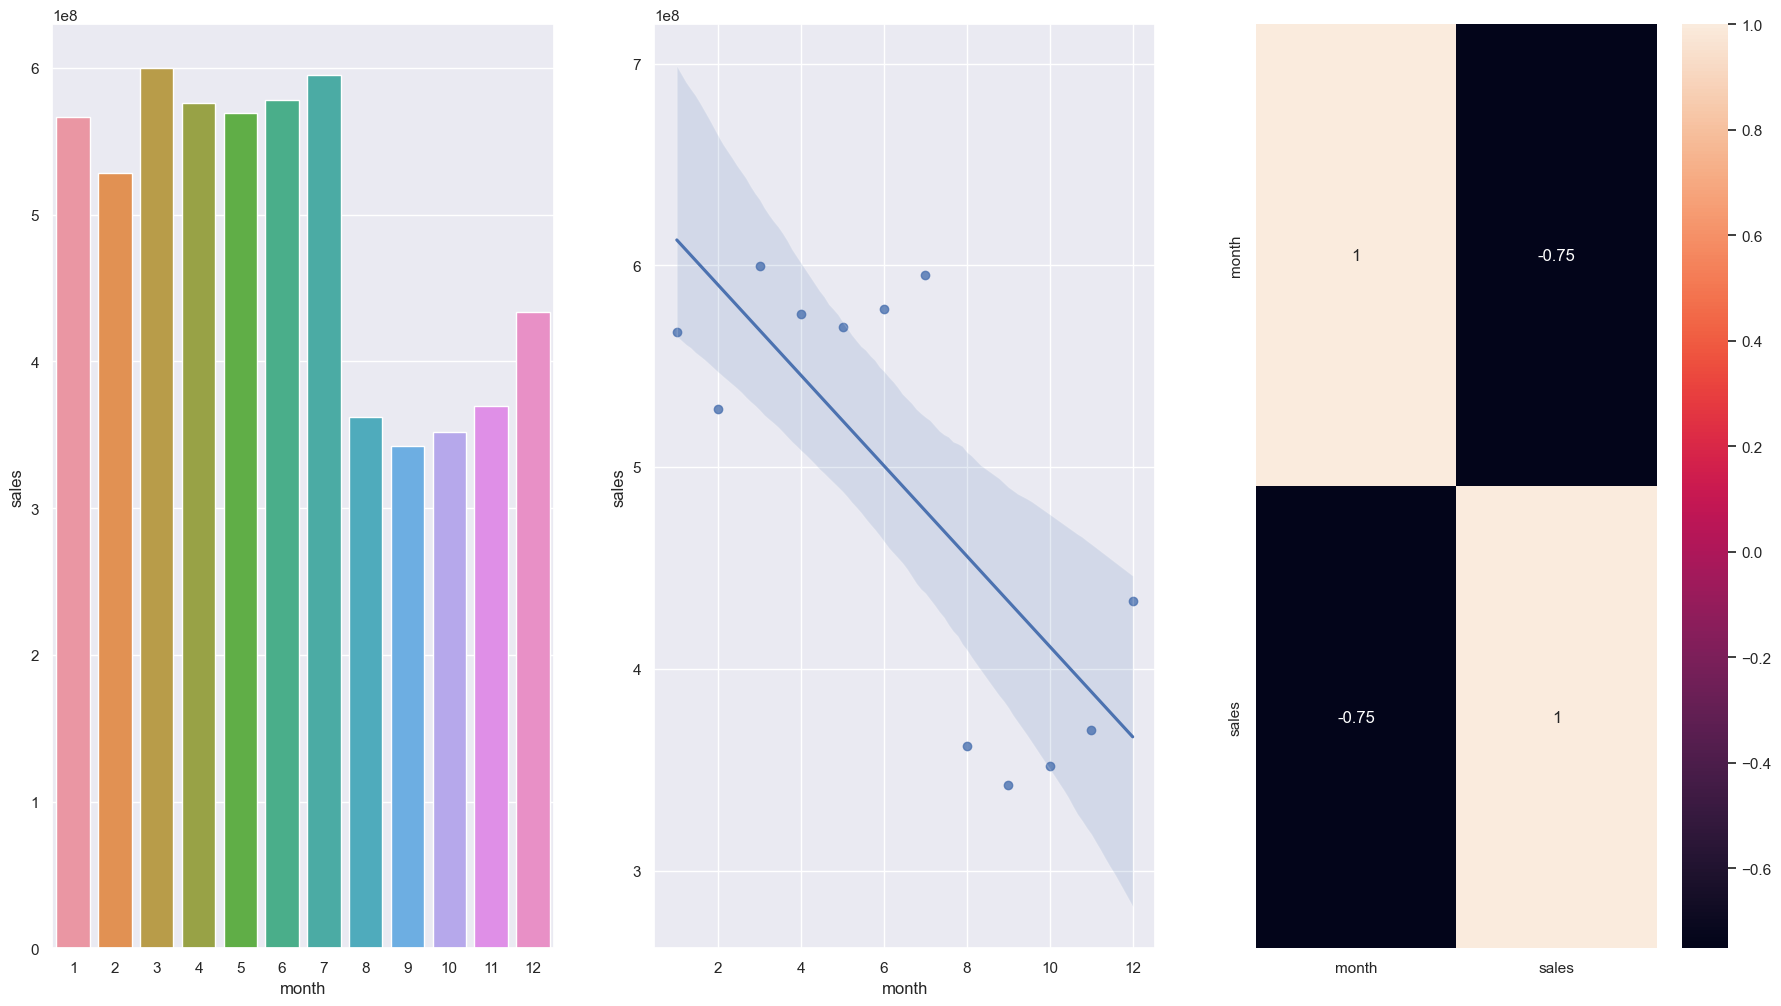

In [97]:
h8 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data= h8);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data= h8);

plt.subplot(1,3,3)
sns.heatmap(h8.corr(method='pearson'), annot= True)

### H9. Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

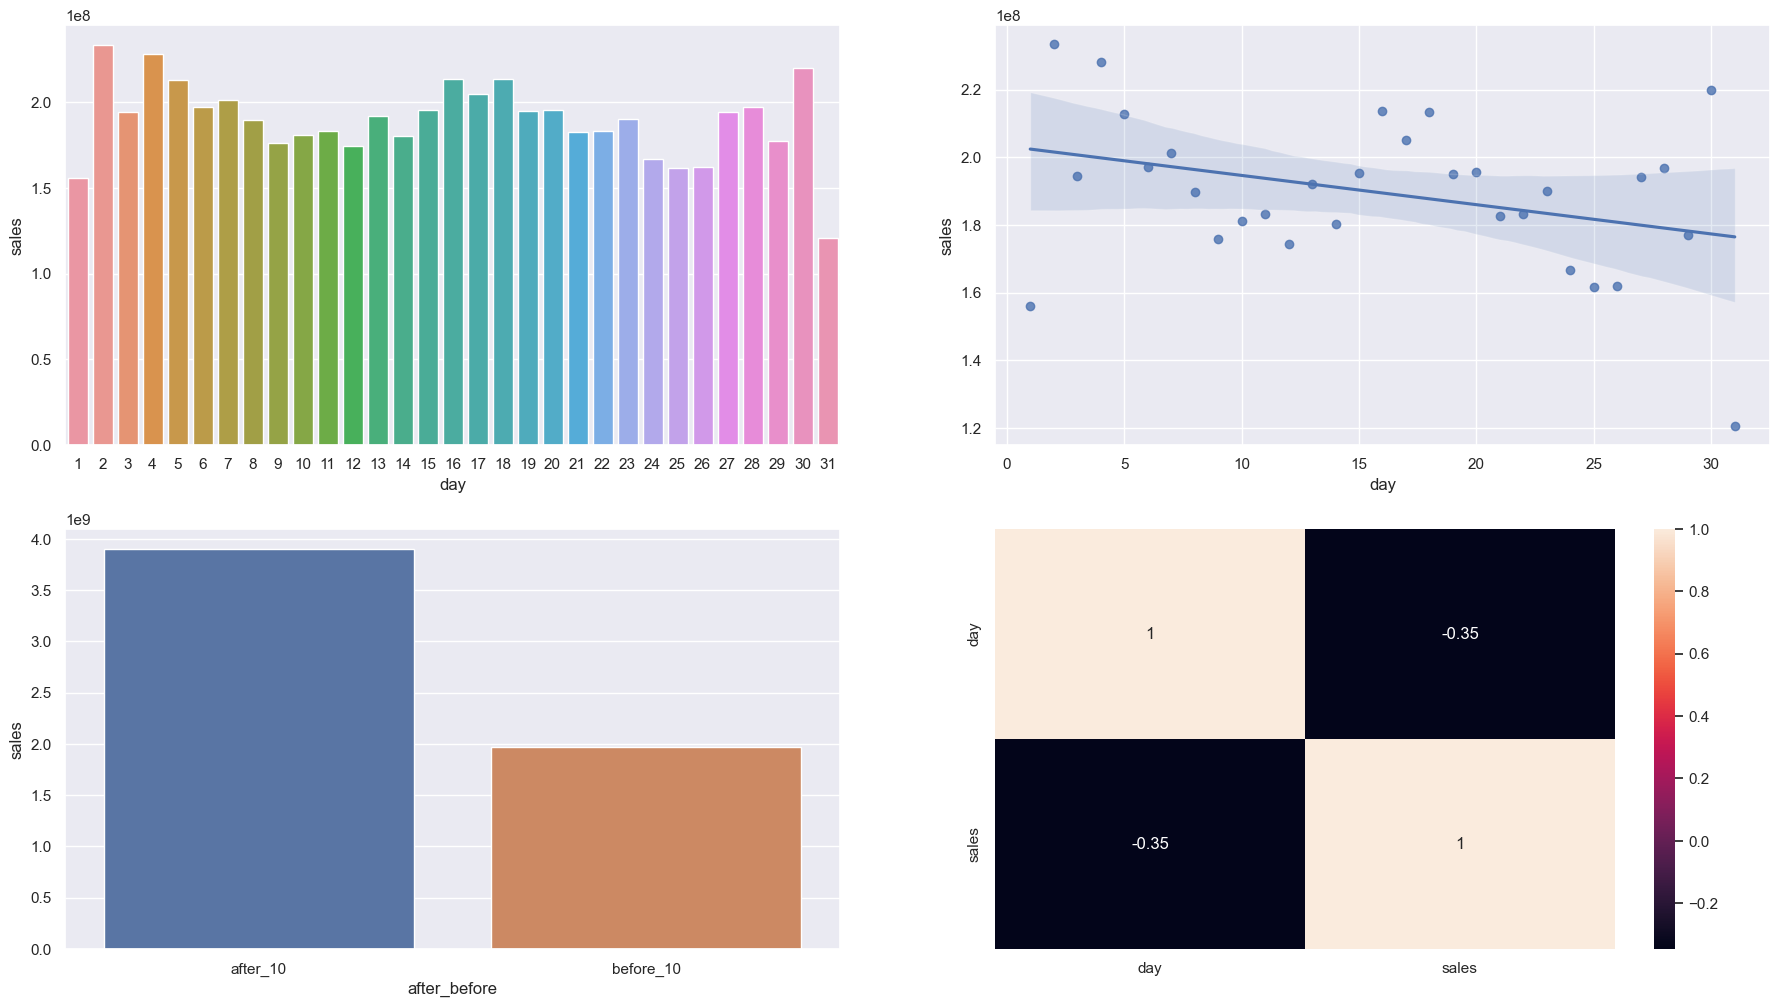

In [98]:
plt.subplot(2,2,1)
h9 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x = 'day', y = 'sales', data = h9)

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = h9)

plt.subplot(2,2,3)
h9['after_before'] = h9['day'].apply(lambda x: 'before_10' if x <= 10 else 'after_10')

h9_aux1 = h9[['after_before', 'sales']].groupby('after_before').sum().reset_index()
sns.barplot(x='after_before', y='sales', data = h9_aux1);

plt.subplot(2, 2, 4)
sns.heatmap(h9.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas vendem menos aos finais de semana

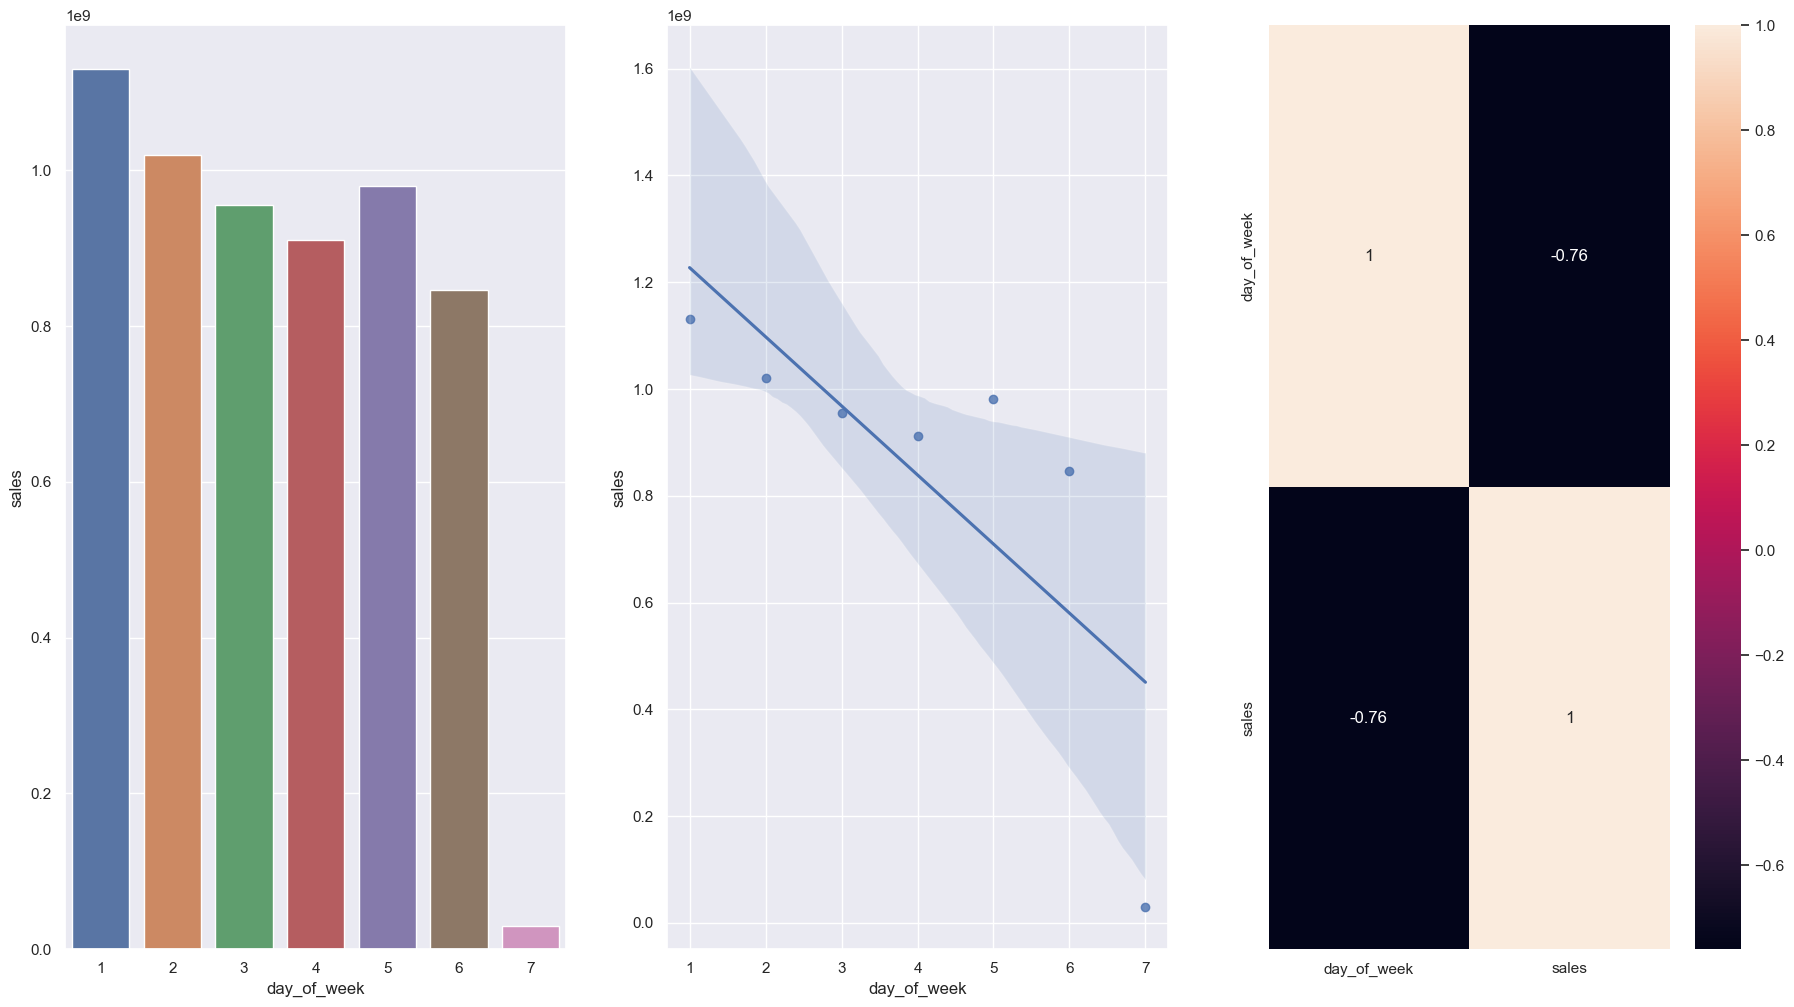

In [99]:
h10 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y = 'sales', data= h10);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data= h10);

plt.subplot(1,3,3)
sns.heatmap(h10.corr(method='pearson'), annot= True);

### H11. Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos durantes os feriados escolares

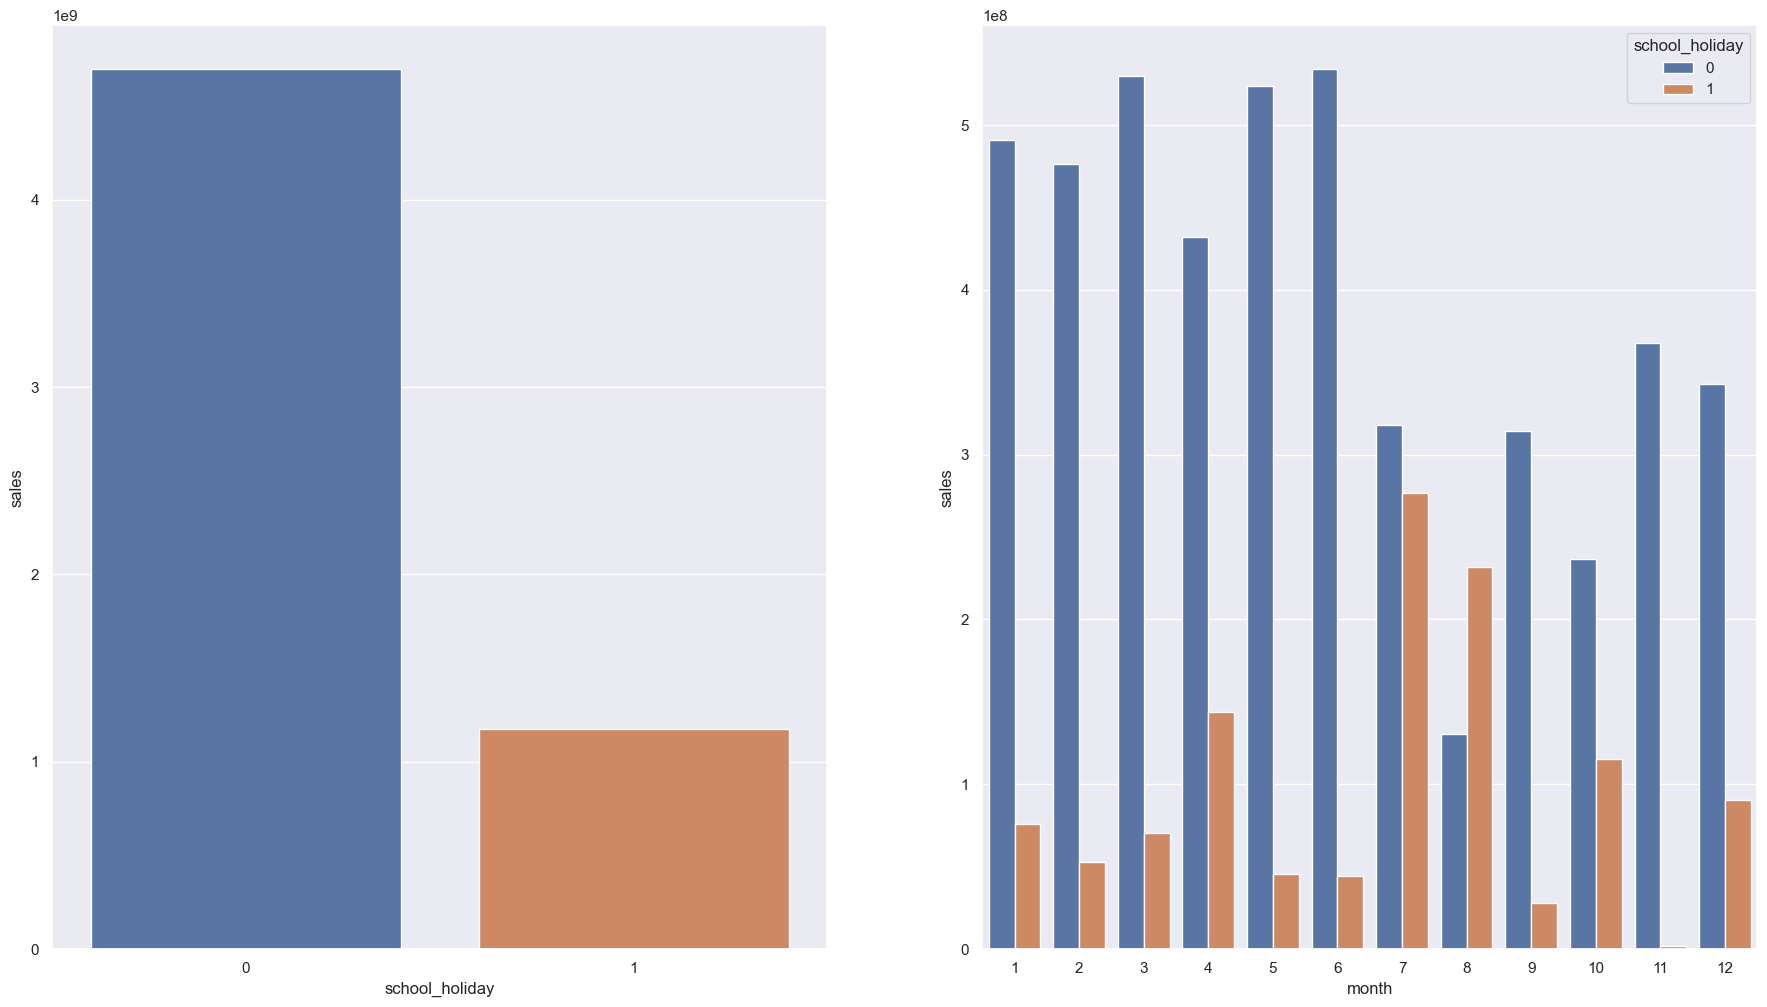

In [100]:
plt.subplot(1,2,1)
h11 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=h11 );

plt.subplot(1,2,2)
h11_aux = df4[['school_holiday', 'month',  'sales']].groupby(['school_holiday', 'month']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=h11_aux);

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes 

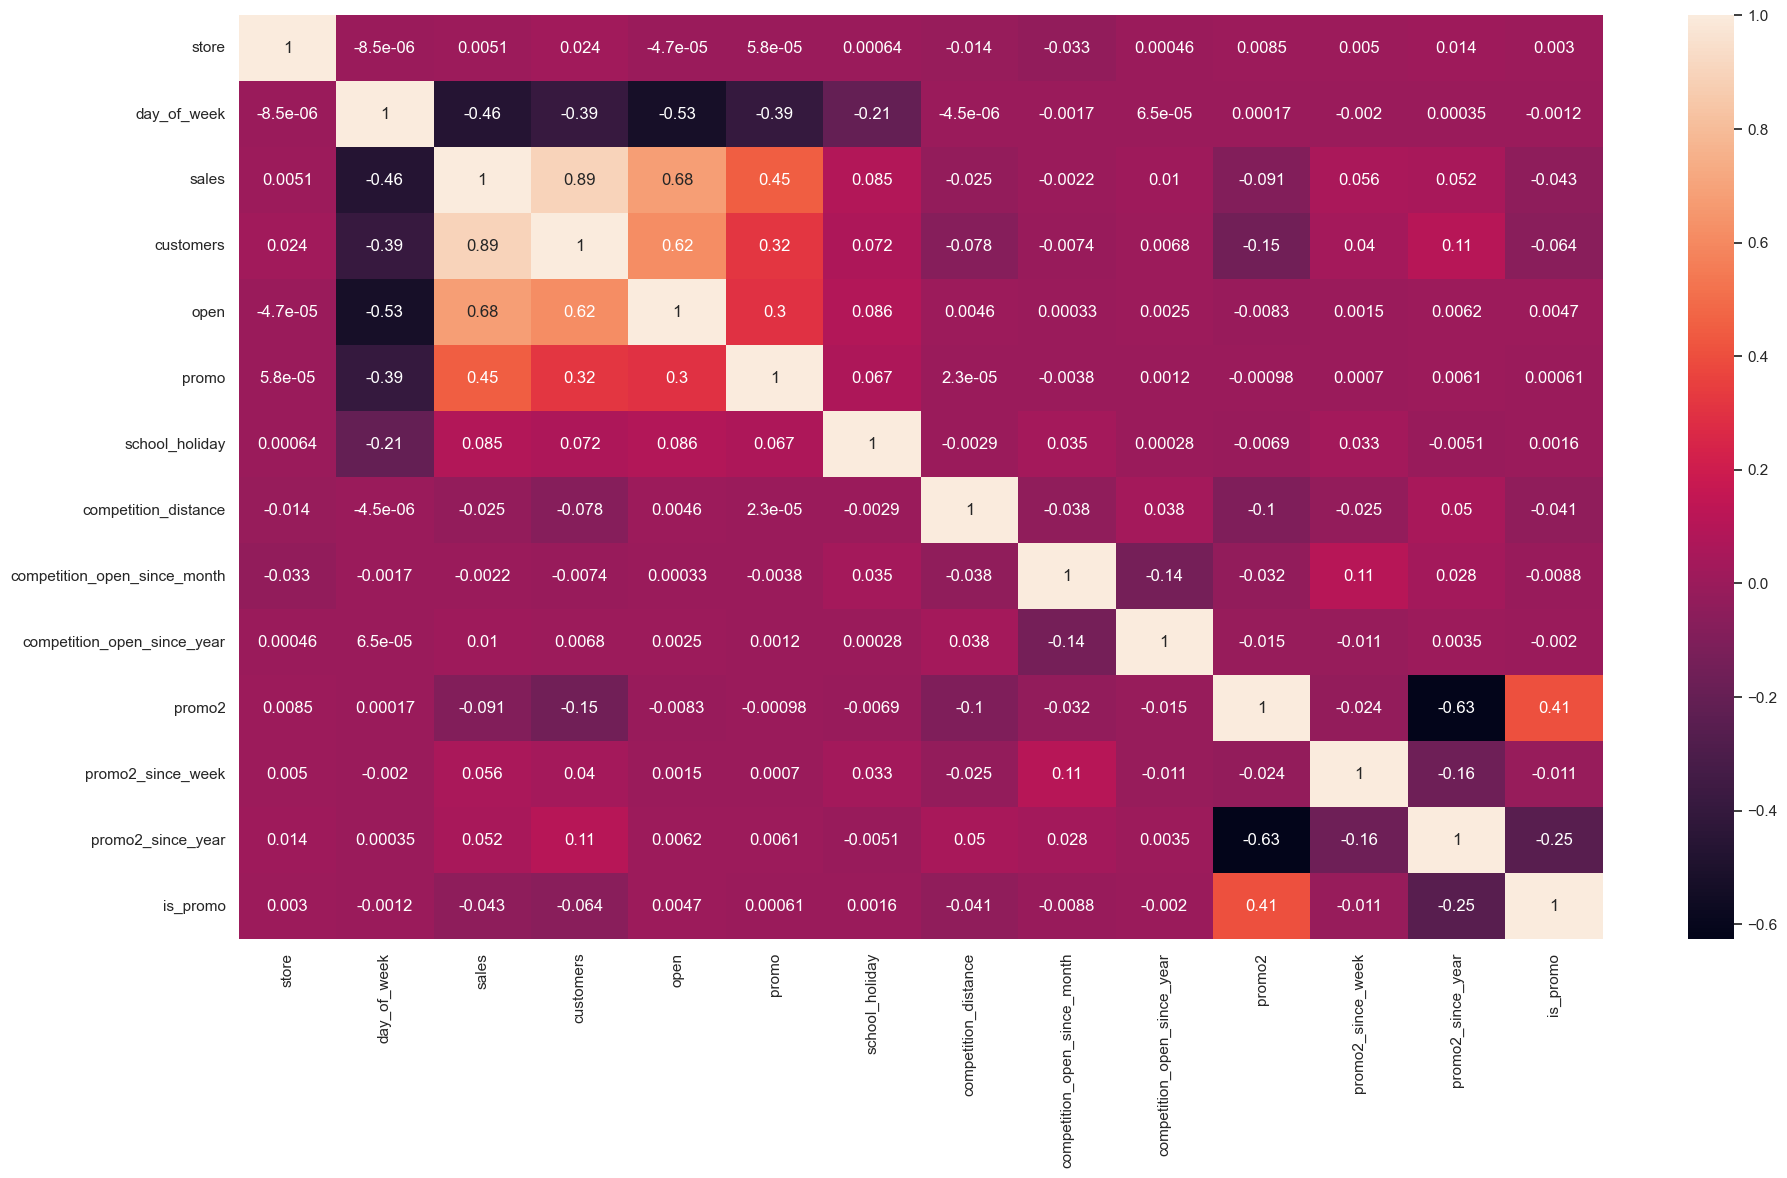

In [101]:
sns.heatmap(num_attributes.corr(method='pearson'), annot=True);

### 4.3.2. Categorical Attributes 

In [102]:
cat_attributes = df4.select_dtypes(include='object')

In [103]:
a1 = cramer_v(cat_attributes['state_holiday'], cat_attributes['state_holiday'])
a2 = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type'])
a3 = cramer_v(cat_attributes['state_holiday'], cat_attributes['assortment'])

a4 = cramer_v(cat_attributes['store_type'], cat_attributes['state_holiday'])
a5 = cramer_v(cat_attributes['store_type'], cat_attributes['store_type'])
a6 = cramer_v(cat_attributes['store_type'], cat_attributes['assortment'])

a7 = cramer_v(cat_attributes['assortment'], cat_attributes['state_holiday'])
a8 = cramer_v(cat_attributes['assortment'], cat_attributes['store_type'])
a9 = cramer_v(cat_attributes['assortment'], cat_attributes['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

<AxesSubplot:>

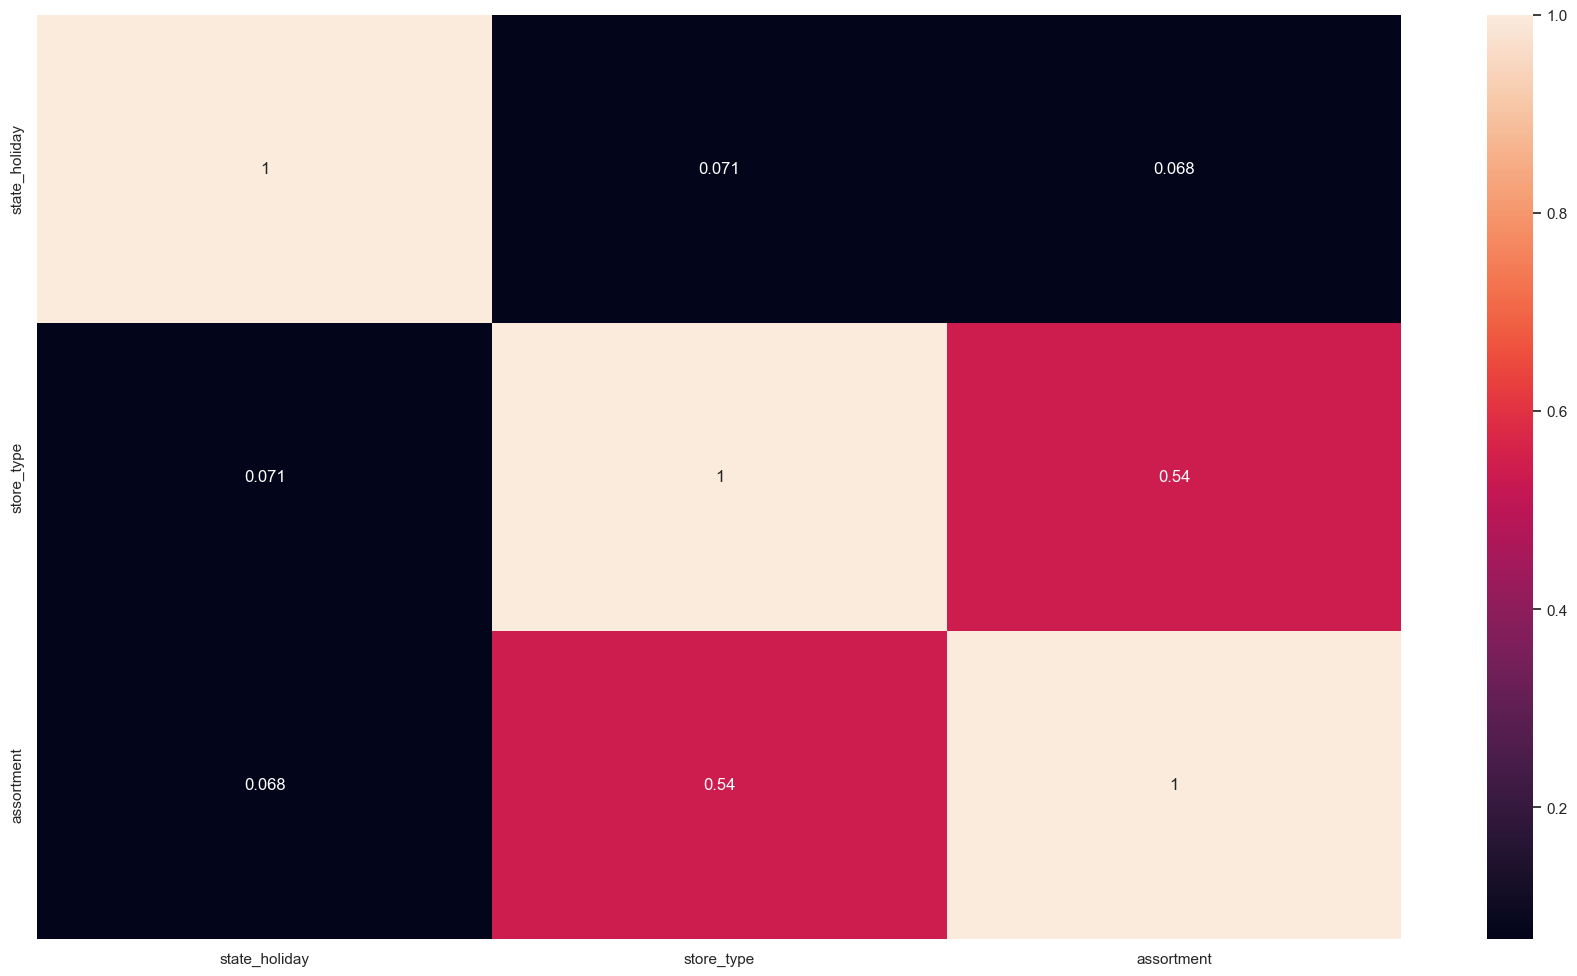

In [104]:
sns.heatmap(d, annot=True)

# 5.0. DATA PREPARATION

In [105]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling 

In [106]:
# numerical data
df5_numerical = df5.select_dtypes(include=['float', 'int64'])

In [108]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open('api/parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open('api/parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open('api/parameter/competition_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open('api/parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1. Encoding 

In [109]:
df5

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,-0.351613,9,2006,0,1,2013,0,0.0,1,1,1,2013-00,2006-09-01,0.824324,2012-12-31,0.287016
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,-0.237097,10,1999,0,1,2013,0,0.0,1,1,1,2013-00,1999-10-01,1.959459,2012-12-31,0.287016
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,-0.240323,1,2013,1,48,2012,1,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-11-19,0.300683
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,-0.145161,1,2013,0,1,2013,0,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-12-31,0.287016


In [110]:
# state holiday - ohe
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - le
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open('api/parameter/store_type_scaler.pkl', 'wb'))

# assortment - oe
assortment_d = {'basic':1, 'extra':2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_d)

### 5.3.2. Response variable transformation 

In [111]:
df5['sales'] = np.log1p(df4['sales'])

<AxesSubplot:xlabel='sales'>

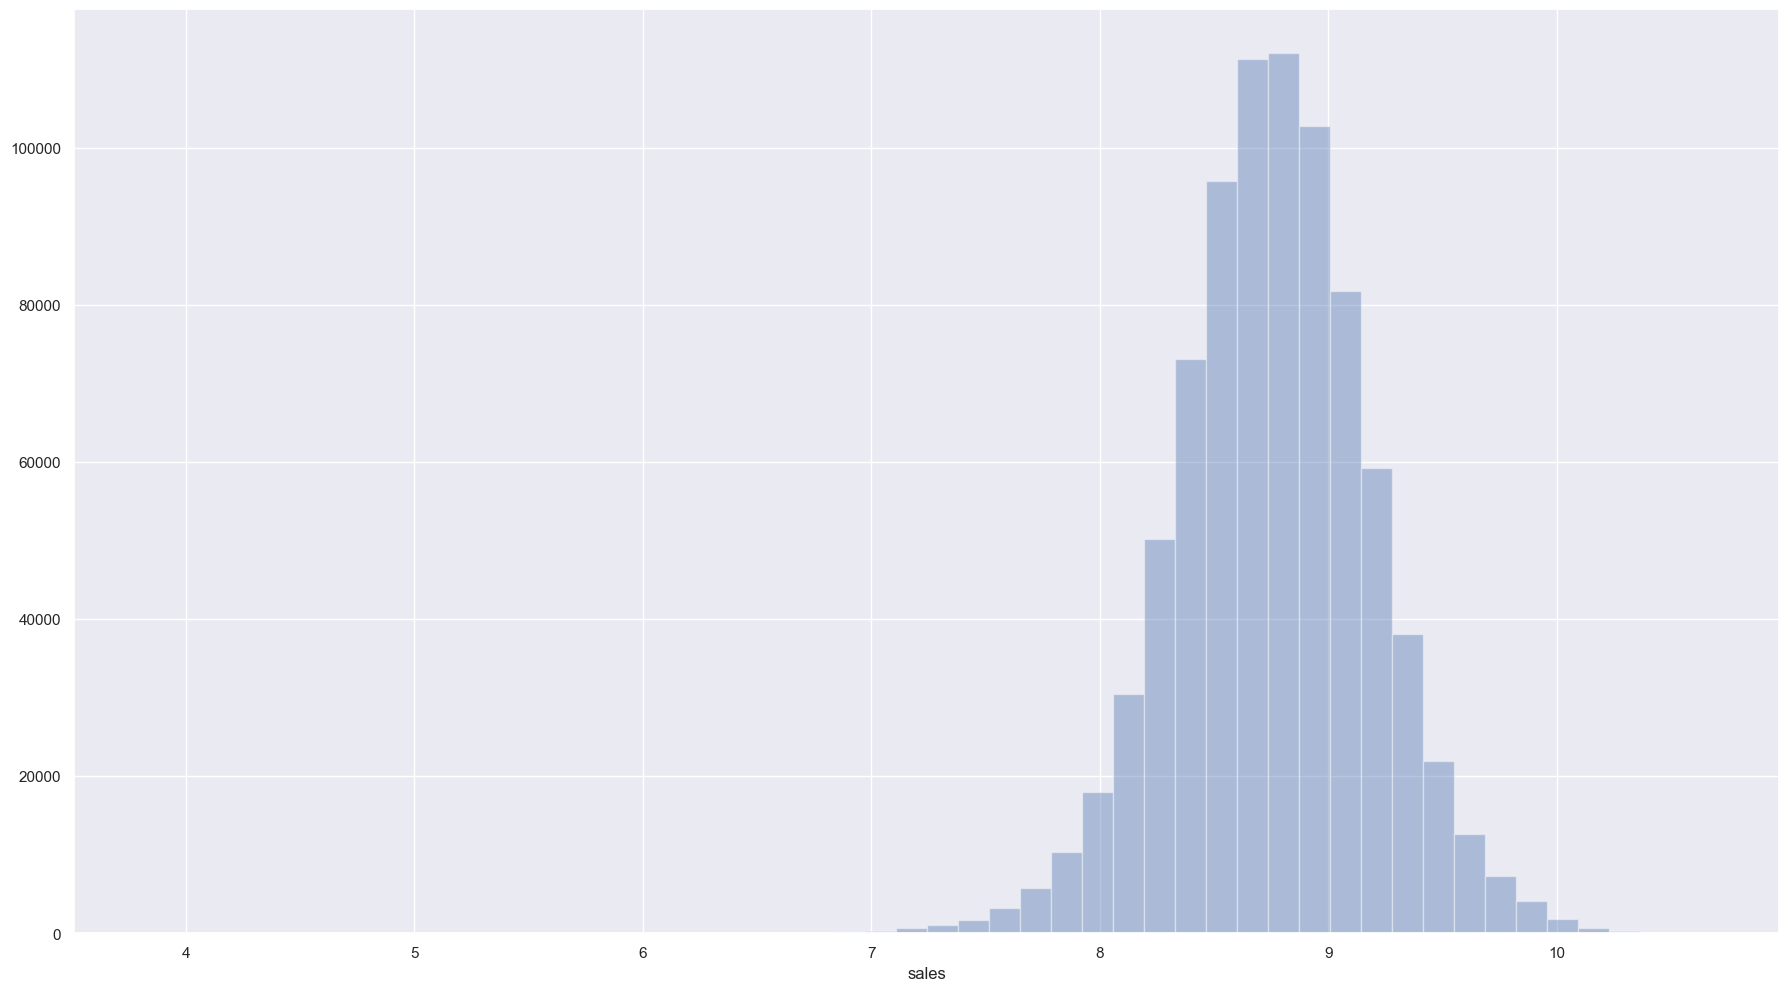

In [112]:
sns.distplot(df5['sales'], kde = False)

### 5.3.3. Nature transformation 

In [113]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 )))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 )))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 )))

# 6.0. FEATURE SELECTION

In [114]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [115]:
# Dropping columns which i used to create other features
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

# Six weeks before
print('6 weeks before: {} \n'.format( df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7) ) )

# Training dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

6 weeks before: 2015-06-19 00:00:00 

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector 

In [116]:
# # Random Forest Regressor
# rf = RandomForestRegressor()

# # Training and test dataset for boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# boruta = BorutaPy(rf, n_estimators='auto', verbose = 2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [117]:
# cols_selected = boruta.support_.tolist()

# X_train_fs = X_train.drop(['date', 'sales'], axis = 1)

# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

## 6.3. Manual Feature Selection 

In [119]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'day_sin',
    'day_cos',
    'month_sin',
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [120]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. MACHINE LEARNING MODELING

In [121]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model 

In [122]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

In [123]:
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns= {'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

# predict
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name:,MAE:,MAPE:,RMSE:
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression 

In [124]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# result
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name:,MAE:,MAPE:,RMSE:
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression - Cross Validation 

In [125]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1992.27+/-41.68,0.29+/-0.01,2846.37+/-87.77


## 7.3. Linear Regression Regularized Model

In [126]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# predict
yhat_lrr = lrr.predict(x_test)

# result
lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name:,MAE:,MAPE:,RMSE:
0,Lasso,1891.704881,0.289106,2744.45174


###  7.3.1. Lasso - Cross Validation

In [127]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2035.84+/-54.02,0.29+/-0.0,2964.68+/-89.66


## 7.4. Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor(n_estimators= 100, n_jobs = -1, random_state=42).fit(x_train, y_train)

# predict
yhat_rf = rf.predict(x_test)

# result
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf)
rf_result_cv

## 7.5. XGBoost Regressor

In [ ]:
# model
model_xgb = XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# predict
yhat_xgb = model_xgb.predict(x_test)

# result
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

### 7.5.1. XGBoost Regressor - Cross Validation 

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb)
xgb_result_cv

## 7.6. Compare Model's Perfomance

### 7.6.1. Single Performance 

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values('RMSE:')

### 7.6.2. Real Performance - Cross Validation 

In [ ]:
modelling_result = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result.sort_values('RMSE:')

# 8.0. HYPERPARAMETER FINE TUNNING

## 8.1. Random Search

In [128]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 1

In [ ]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    
    model_xgb = XGBRegressor(objective='reg:squarederror', 
                             n_estimators=hp['n_estimators'],
                             eta=hp['eta'],
                             max_depth=hp['max_depth'],
                             subsample=hp['subsample'],
                             colsample_bytree=hp['colsample_bytree'],
                             min_child_weight=hp['min_child_weight'])
    
    #performance
    result = cross_validation(x_training, 5, 'XGBoost', model_xgb)
    final_result = pd.concat([final_result, result])

final_result

## 8.2. Final Model

In [129]:
# best params
param_tunned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

In [130]:
model_xgb_tunned = XGBRegressor(objective='reg:squarederror', 
                                n_estimators=param_tunned['n_estimators'],
                                eta=param_tunned['eta'],
                                max_depth=param_tunned['max_depth'],
                                subsample=param_tunned['subsample'],
                                colsample_bytree=param_tunned['colsample_bytree'],
                                min_child_weight=param_tunned['min_child_weight']).fit(x_train, y_train)
  
# predict
yhat_xgb_tunned = model_xgb_tunned.predict(x_test)

# result
result_tunned = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb_tunned))
result_tunned

,Model Name:,MAE:,MAPE:,RMSE:
0,XGBoost,767.819972,0.11494,1104.724995


In [ ]:
mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb))

# 9.0. ERROR TRANSLATION AND INTERPRETATION

In [197]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tunned)

## 9.1. Business Performance

In [198]:
# sum of predictions
df9_aux = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# mae & mape
df9_aux_mae = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux_mape = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# result
df9_aux_merged = pd.merge(df9_aux_mae, df9_aux_mape, how='inner', on='store')
df9_final = pd.merge(df9_aux, df9_aux_merged, how='inner', on='store')

# scenarios
df9_final['worst_scenario'] = df9_final['predictions'] - df9_final['MAE']
df9_final['best_scenario'] =  df9_final['predictions'] + df9_final['MAE']

# order columns
df9_final = df9_final[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [199]:
df9_final.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,166355.312500,166064.778479,166645.846521,290.534021,0.066464
1,2,180542.734375,180135.002527,180950.466223,407.731848,0.082298
2,3,268542.406250,267891.449945,269193.362555,650.956305,0.090934
3,4,344907.562500,344066.401737,345748.723263,841.160763,0.080316
4,5,169234.062500,168890.522771,169577.602229,343.539729,0.077053


## 9.2. Total Performance

In [200]:
total_performance = df9_final[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index':'scenario', 0:'values'})
total_performance['values'] = total_performance['values'].map('R${:,.2f}'.format)
total_performance

,scenario,values
0,predictions,"R$285,259,968.00"
1,worst_scenario,"R$284,400,731.81"
2,best_scenario,"R$286,119,198.61"


## 9.3. Machine Learning Performance

In [201]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

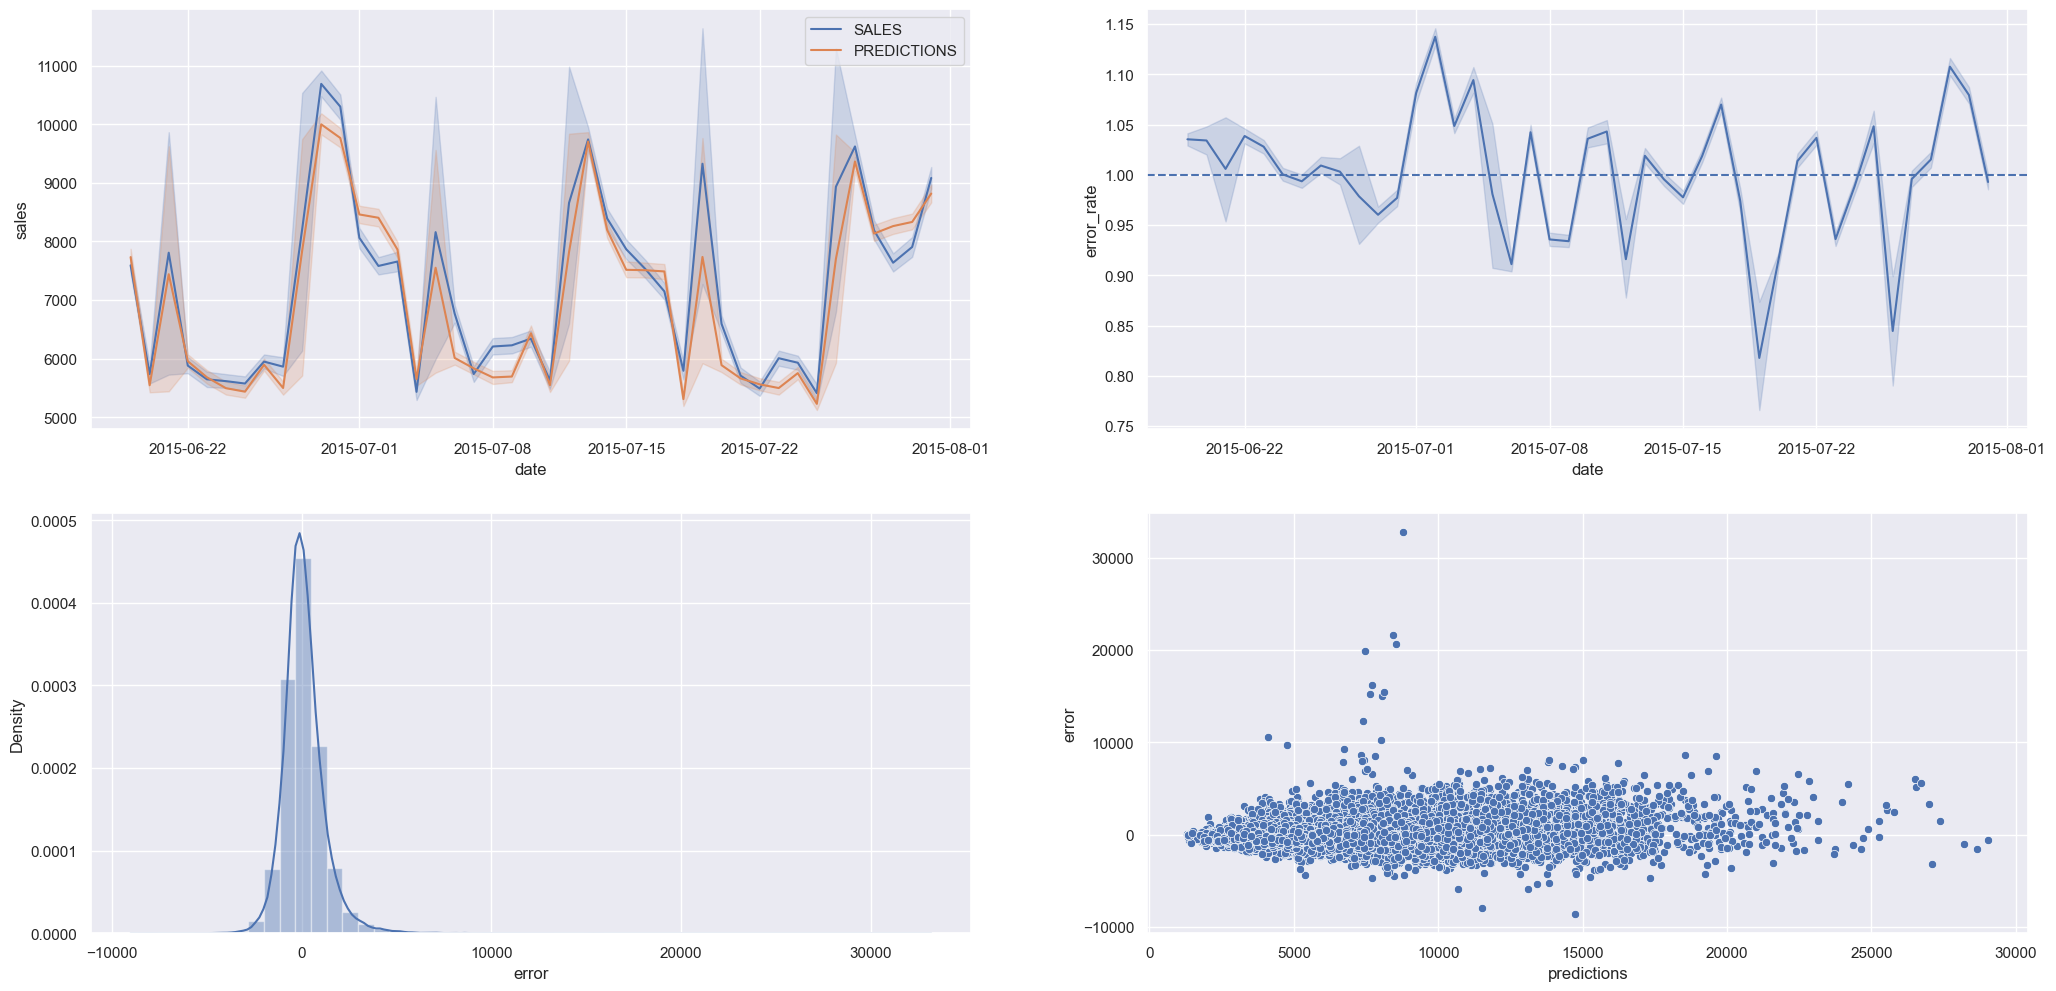

In [202]:
plt.subplot(2, 2, 1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'SALES')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline( 1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x = 'predictions', y = 'error', data = df9);